In [3]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle
import yaml
from pathlib import Path

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-05-29 11:42:05.555924: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 11:42:05.798371: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-29 11:42:05.798409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-29 11:42:05.822382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 11:42:05.904876: I tensorflow/core/platform/cpu_feature_guar

In [4]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Muchisimocks estimate

### Fixed-parameter set to estimate covariance:

In [30]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params_cv = '_quijote_p0_n1000'
tag_biasparams_cv = '_b1000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params_cv + tag_biasparams_cv + tag_datagen

In [31]:
k_cv, y_cv, y_err_cv, idxs_params, params_df_cv, param_dict_fixed_cv, biasparams_df_cv, biasparams_dict_fixed_cv, random_ints_cosmo_cv, random_ints_bias_cv = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params_cv, tag_biasparams_cv,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k_cv, y_cv, y_err_cv = k_cv[0], y_cv[0], y_err_cv[0]

Loading muchisimocks data
_b1000_p0_n1
Found 1000 pks in /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_quijote_p0_n1000_b1000_p0_n1
dir statistics /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_quijote_p0_n1000_b1000_p0_n1
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt (already exists)
Masked 1 out of 30 bins


In [32]:
# this should align with y_cv
param_names_cv = data_loader.get_param_names(tag_params=tag_params_cv, tag_biasparams=tag_biasparams_cv)

In [19]:
params_dict_cv = param_dict_fixed_cv.copy()
params_dict_cv.update(biasparams_dict_fixed_cv)
print(params_dict_cv)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'b1': 1, 'b2': 0, 'bs2': 0, 'bl': 0}


In [20]:
cov_fid = np.cov(y_cv, rowvar=False)
print(cov_fid.shape)

(29, 29)


In [21]:
cond_cov = np.linalg.cond(cov_fid)
print("Condition number of cov_fid:", cond_cov)

Condition number of cov_fid: 11603585.349807065


In [22]:
corr_fid = cov_fid / np.sqrt(np.outer(np.diag(cov_fid), np.diag(cov_fid)))

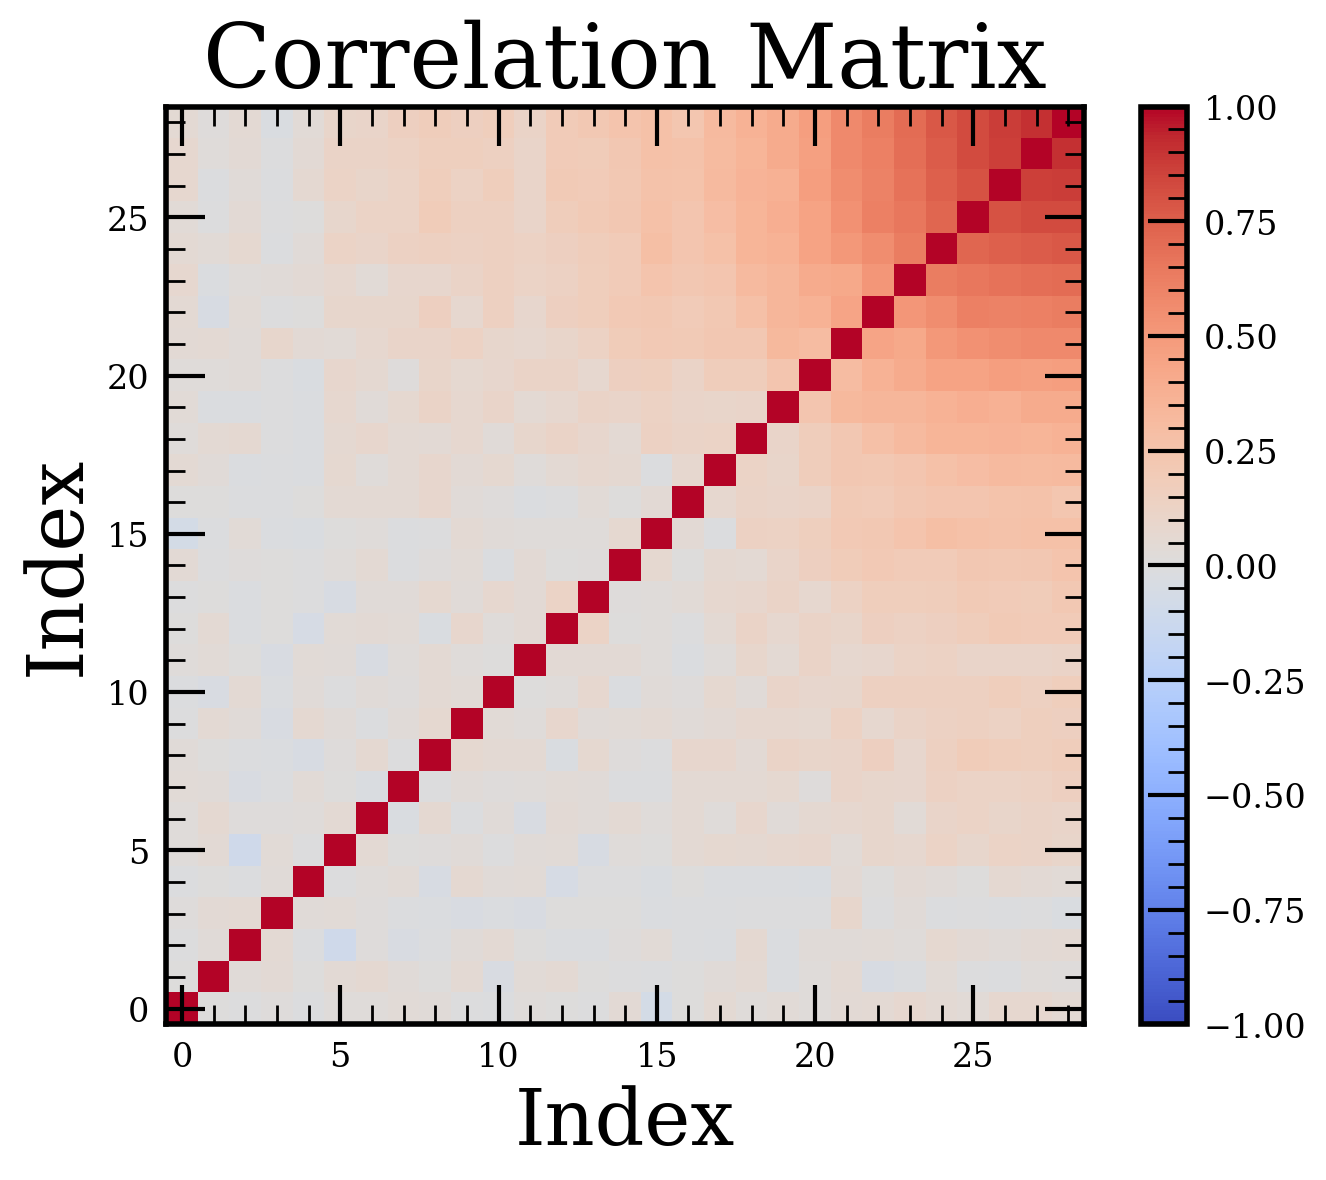

In [23]:
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_fid, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal', origin='lower')
plt.title('Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Index')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [ ]:
data_mode_emu = 'emu'
statistics = ['pk']

tag_params = '_quijote_p0_n1000'
tag_biasparams = '_b1000_p0_n1'
tag_errG = '_boxsize1000'
n_rlzs_per_cosmo = 1
tag_noiseless = ''
#tag_noiseless = '_noiseless' # if use noiseless, set evaluate_mean=False (?)
tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
kwargs_data = {'n_rlzs_per_cosmo': n_rlzs_per_cosmo,
                    'tag_errG': tag_errG,
                    'tag_datagen': tag_datagen,
                    'tag_noiseless': tag_noiseless}
    
tag_stats = f'_{"_".join(statistics)}'    
tag_data_emu = '_'+data_mode_emu + tag_stats + tag_params + tag_biasparams + tag_datagen

In [ ]:
k_cv_emu, y_cv_emu, y_err_cv_emu, idxs_params_emu, params_df_cv_emu, param_dict_fixed_cv_emu, biasparams_df_cv_emu, biasparams_dict_fixed_cv_emu, random_ints_cosmo_cv_emu, random_ints_bias_cv_emu = \
            data_loader.load_data(data_mode_emu, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k_cv_emu, y_cv_emu, y_err_cv_emu = k_cv_emu[0], y_cv_emu[0], y_err_cv_emu[0]

../data/emuPks/emuPks_quijote_p0_n1000_b1000_p0_n1/emuPks_noisy_boxsize1000_nrlzs1.npy
(1000, 30)
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt (already exists)
Masked 1 out of 30 bins


### Varying-parameter set to estimate derivatives:

In [11]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [12]:
k, y, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, random_ints_cosmo, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k, y, y_err = k[0], y[0], y_err[0]
print(y.shape)
print(k.shape)

Loading muchisimocks data
_biaszen_p4_n10000
dir statistics /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000


Loaded pk data with shape (10000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_p5_n10000_biaszen_p4_n10000.txt
Loading from ../data/masks/mask_muchisimocks_pk_p5_n10000_biaszen_p4_n10000.txt (already exists)
Masked 1 out of 30 bins
(10000, 29)
(29,)


In [28]:
# for fisher, this param_names has the non-param columns, careful
theta, param_names = data_loader.param_dfs_to_theta(params_df, biasparams_df)
theta_fid = [params_dict_cv[param] for param in utils.param_names_all_ordered]
print(theta.shape, param_names)

(21, 7) ['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'param_shifted', 'n_deltas']


In [29]:
# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
extents = {**dict_bounds_cosmo, **dict_bounds_bias}

ValueError: Unknown tag_bounds _quijote_p0_n1000

In [15]:
extents

{'omega_cold': [0.23, 0.4],
 'omega_baryon': [0.04, 0.06],
 'sigma8_cold': [0.65, 0.9],
 'ns': [0.92, 1.01],
 'hubble': [0.6, 0.8],
 'neutrino_mass': [0.0, 0.4],
 'w0': [-1.15, -0.85],
 'wa': [-0.3, 0.3],
 'b1': [-1, 2],
 'b2': [-2, 2],
 'bs2': [-2, 2],
 'bl': [-10, 10]}

In [16]:
def fit_derivatives_from_grid(parameters_array, spectra_array, fiducial_params,
                              param_names=None, thresh_std=0.8,
                              extents=None):
    """
    parameters_array: shape (1000, n_params) - the parameters for each spectrum
    spectra_array: shape (1000, n_ell) - the corresponding power spectra
    fiducial_params: shape (n_params,) - your fiducial parameter values
    """
    derivatives = {}
    n_params = len(fiducial_params)

    if param_names is None:
        param_names = [f'param_{i}' for i in range(n_params)]

    for i in range(n_params):
        # Find spectra close to fiducial in all parameters except i-th
        mask = np.ones(len(parameters_array), dtype=bool)
        for j in range(n_params):
            if j != i:
                # Keep only spectra where other parameters are close to fiducial
                #param_range = np.std(parameters_array[:, j]) * thresh_std  # x% of std
                param_range = np.abs(np.diff(extents[param_names[j]]))/4
                mask &= np.abs(parameters_array[:, j] - fiducial_params[j]) < param_range
            else:
                # get ones at least reasonable close to fiducial
                param_range_var = np.abs(np.diff(extents[param_names[j]]))/2
                if extents is not None: 
                    mask &= np.abs(parameters_array[:, j] - fiducial_params[j]) < param_range_var
        
        print(param_names[i], np.sum(mask), param_range_var)
        if np.sum(mask) < 10:  # Need enough points
            raise ValueError(f"Not enough data points for parameter {i}")
        
        # Fit linear relationship between parameter i and spectra
        param_vals = parameters_array[mask, i]
        spectra_subset = spectra_array[mask]
        
        # Fit slope for each multipole
        derivatives[param_names[i]] = np.array([
            np.polyfit(param_vals, spectra_subset[:, ell], 1)[0] 
            for ell in range(spectra_subset.shape[1])
        ])
    
    return derivatives

In [17]:
derivatives = fit_derivatives_from_grid(
    parameters_array=theta,
    spectra_array=y,
    fiducial_params=theta_fid,
    param_names=param_names,
    extents=extents,
)
print("Derivatives shape:", {k: v.shape for k, v in derivatives.items()})

omega_cold 37 [0.085]
sigma8_cold 27 [0.125]
hubble 35 [0.1]
omega_baryon 29 [0.01]
ns 37 [0.045]
b1 24 [1.5]
b2 45 [2.]
bs2 35 [2.]
bl 40 [10.]
Derivatives shape: {'omega_cold': (29,), 'sigma8_cold': (29,), 'hubble': (29,), 'omega_baryon': (29,), 'ns': (29,), 'b1': (29,), 'b2': (29,), 'bs2': (29,), 'bl': (29,)}


In [14]:
def compute_fisher_matrix(derivatives, covariance_matrix, param_names):
    n_params = len(param_names)
    fisher_matrix = np.zeros((n_params, n_params))
    
    # Invert covariance matrix
    cov_inv = np.linalg.inv(covariance_matrix)
    
    for i, param_i in enumerate(param_names):
        for j, param_j in enumerate(param_names):
            fisher_matrix[i, j] = np.dot(derivatives[param_i], 
                                       np.dot(cov_inv, derivatives[param_j]))
    
    return fisher_matrix

In [19]:
fisher_matrix = compute_fisher_matrix(derivatives, cov_fid, param_names)
cov_fisher = np.linalg.inv(fisher_matrix)
print("Fisher matrix shape:", fisher_matrix.shape)

Fisher matrix shape: (9, 9)


In [20]:
n_samples = 10000
samples = np.random.multivariate_normal(theta_fid, cov_fisher, size=n_samples)


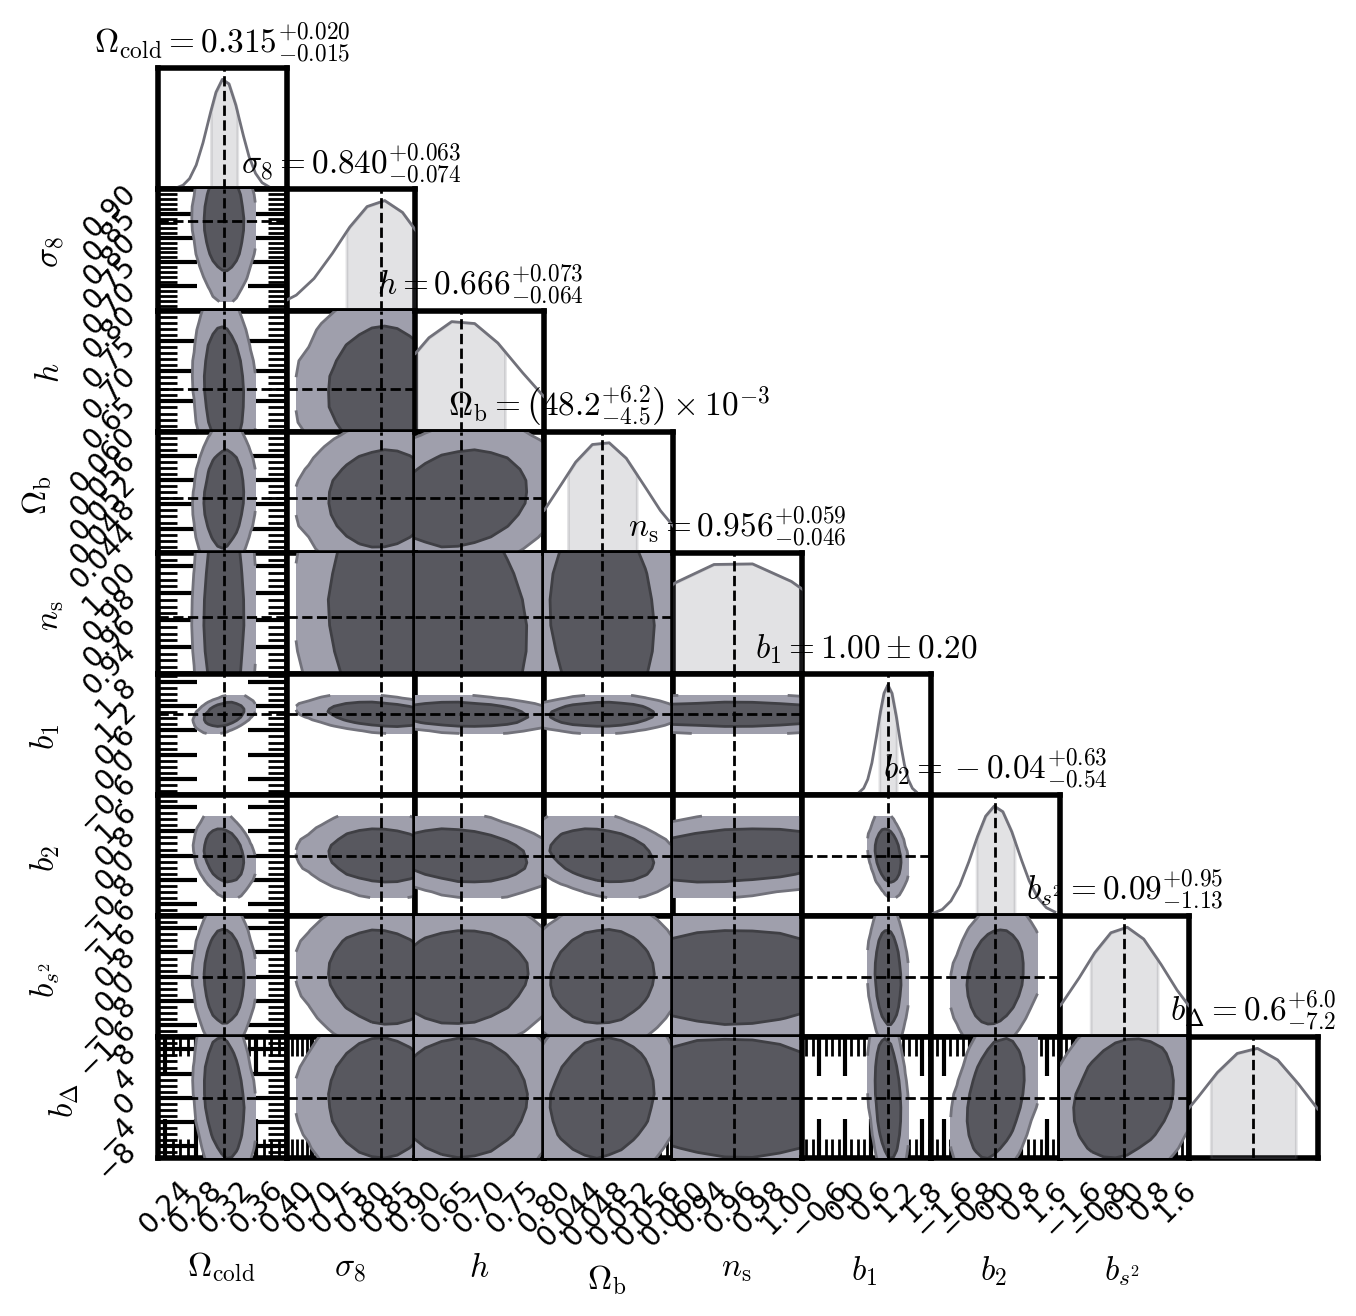

In [21]:

samples_arr = [samples]
labels = ['Fisher']
colors = ['gray']
plotter.plot_contours(samples_arr, labels, colors, param_names, 
                      utils.param_label_dict, 
                  smooth_arr=[2], bins_arr=[4],
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

In [22]:
tag_stats = f'_{"_".join(statistics)}'
# let's just save one per data mode and stats now    
tag_data = '_'+data_mode + tag_stats
tag_inf = tag_data
tag_test = '' #?

#tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
#tag_test = tag_data #?
print(tag_inf)
    
dir_fisher = f'../results/results_fisher/fisher{tag_inf}'
Path.mkdir(Path(dir_fisher), parents=True, exist_ok=True)
        
fn_samples_test_pred = f'{dir_fisher}/samples_test{tag_test}_pred.npy'
np.save(fn_samples_test_pred, samples)

fn_fishmat = f'{dir_fisher}/fisher_matrix.npy'
np.save(fn_fishmat, fisher_matrix)

fn_theta_fid = f'{dir_fisher}/theta_fid.npy'
np.save(fn_theta_fid, theta_fid)

fn_param_names = f'{dir_fisher}/param_names.txt'
np.savetxt(fn_param_names, param_names, fmt='%s')

_muchisimocks_pk


## Emulated dataset:

### Fixed param:

In [23]:
data_mode = 'emu'
statistics = ['pk']

tag_params = '_quijote_p0_n1000'
tag_biasparams = '_b1000_p0_n1'
tag_errG = '_boxsize1000'
n_rlzs_per_cosmo = 1
tag_noiseless = ''
#tag_noiseless = '_noiseless' # if use noiseless, set evaluate_mean=False (?)
tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
kwargs_data = {'n_rlzs_per_cosmo': n_rlzs_per_cosmo,
                    'tag_errG': tag_errG,
                    'tag_datagen': tag_datagen,
                    'tag_noiseless': tag_noiseless}
    
tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [24]:
k_cv_emu, y_cv_emu, y_err_cv_emu, idxs_params_emu, params_df_cv_emu, param_dict_fixed_cv_emu, biasparams_df_cv_emu, biasparams_dict_fixed_cv_emu, random_ints_cosmo_cv_emu, random_ints_bias_cv_emu = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k_cv_emu, y_cv_emu, y_err_cv_emu = k_cv_emu[0], y_cv_emu[0], y_err_cv_emu[0]

../data/emuPks/emuPks_quijote_p0_n1000_b1000_p0_n1/emuPks_noisy_boxsize1000_nrlzs1.npy
(1000, 30)
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_emu_pk_quijote_p0_n1000_b1000_p0_n1_boxsize1000_nrlzs1.txt
Loading from ../data/masks/mask_emu_pk_quijote_p0_n1000_b1000_p0_n1_boxsize1000_nrlzs1.txt (already exists)
Masked 0 out of 30 bins


Text(0, 0.5, '$P(k)\\ [\\mathrm{Mpc}^3/h^3]$')

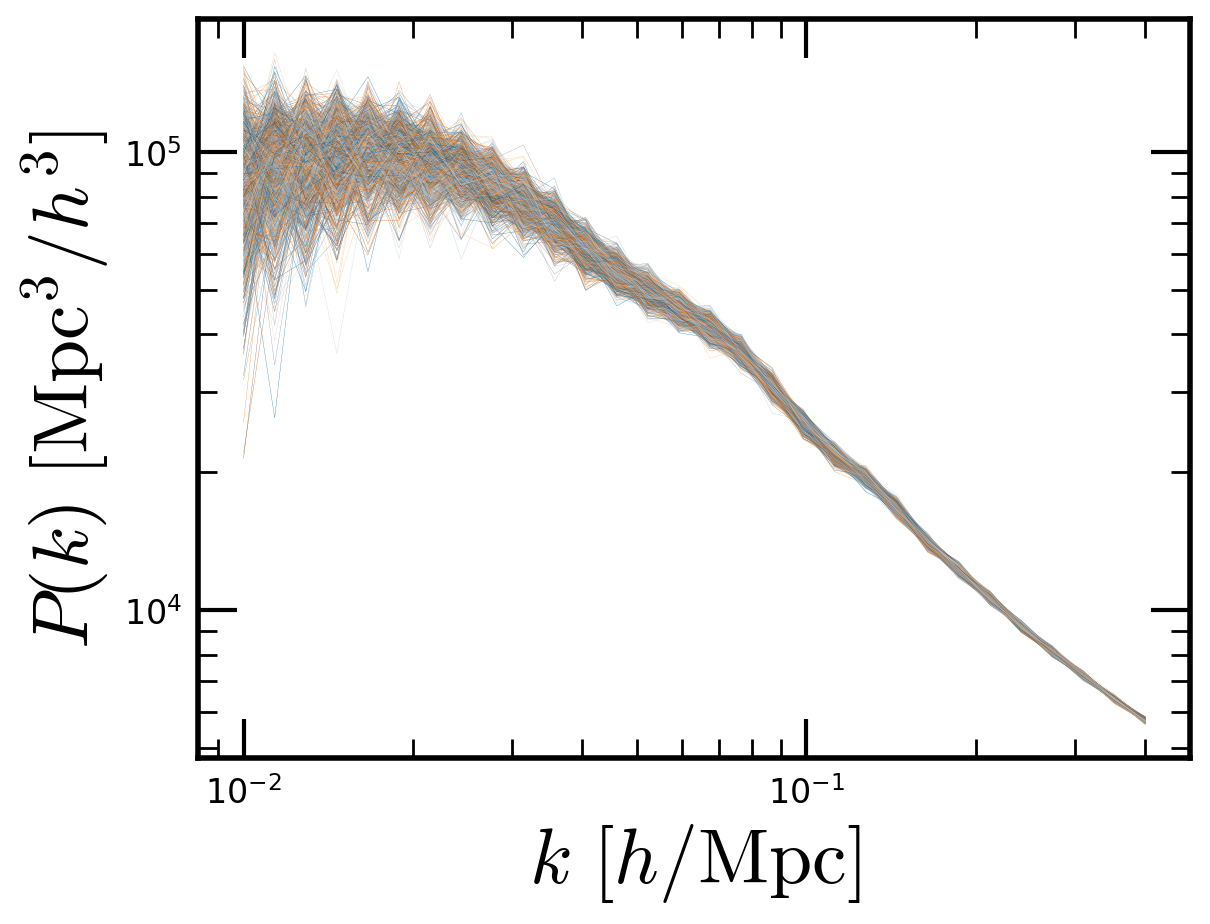

In [25]:
plt.loglog(k_cv_emu, y_cv_emu.T, lw=0.1)
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)\ [\mathrm{Mpc}^3/h^3]$')

In [26]:
params_dict_cv_emu = param_dict_fixed_cv_emu.copy()
params_dict_cv_emu.update(biasparams_dict_fixed_cv_emu)
print(params_dict_cv_emu)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'b1': 1, 'b2': 0, 'bs2': 0, 'bl': 0}


In [27]:
cov_fid_emu = np.cov(y_cv_emu, rowvar=False)
print(cov_fid_emu.shape)

(30, 30)


In [28]:
cond_cov_emu = np.linalg.cond(cov_fid_emu)
print("Condition number of cov_fid_emu:", cond_cov_emu)

Condition number of cov_fid_emu: 388359.5118108527


In [29]:
corr_fid_emu = cov_fid_emu / np.sqrt(np.outer(np.diag(cov_fid_emu), np.diag(cov_fid_emu)))

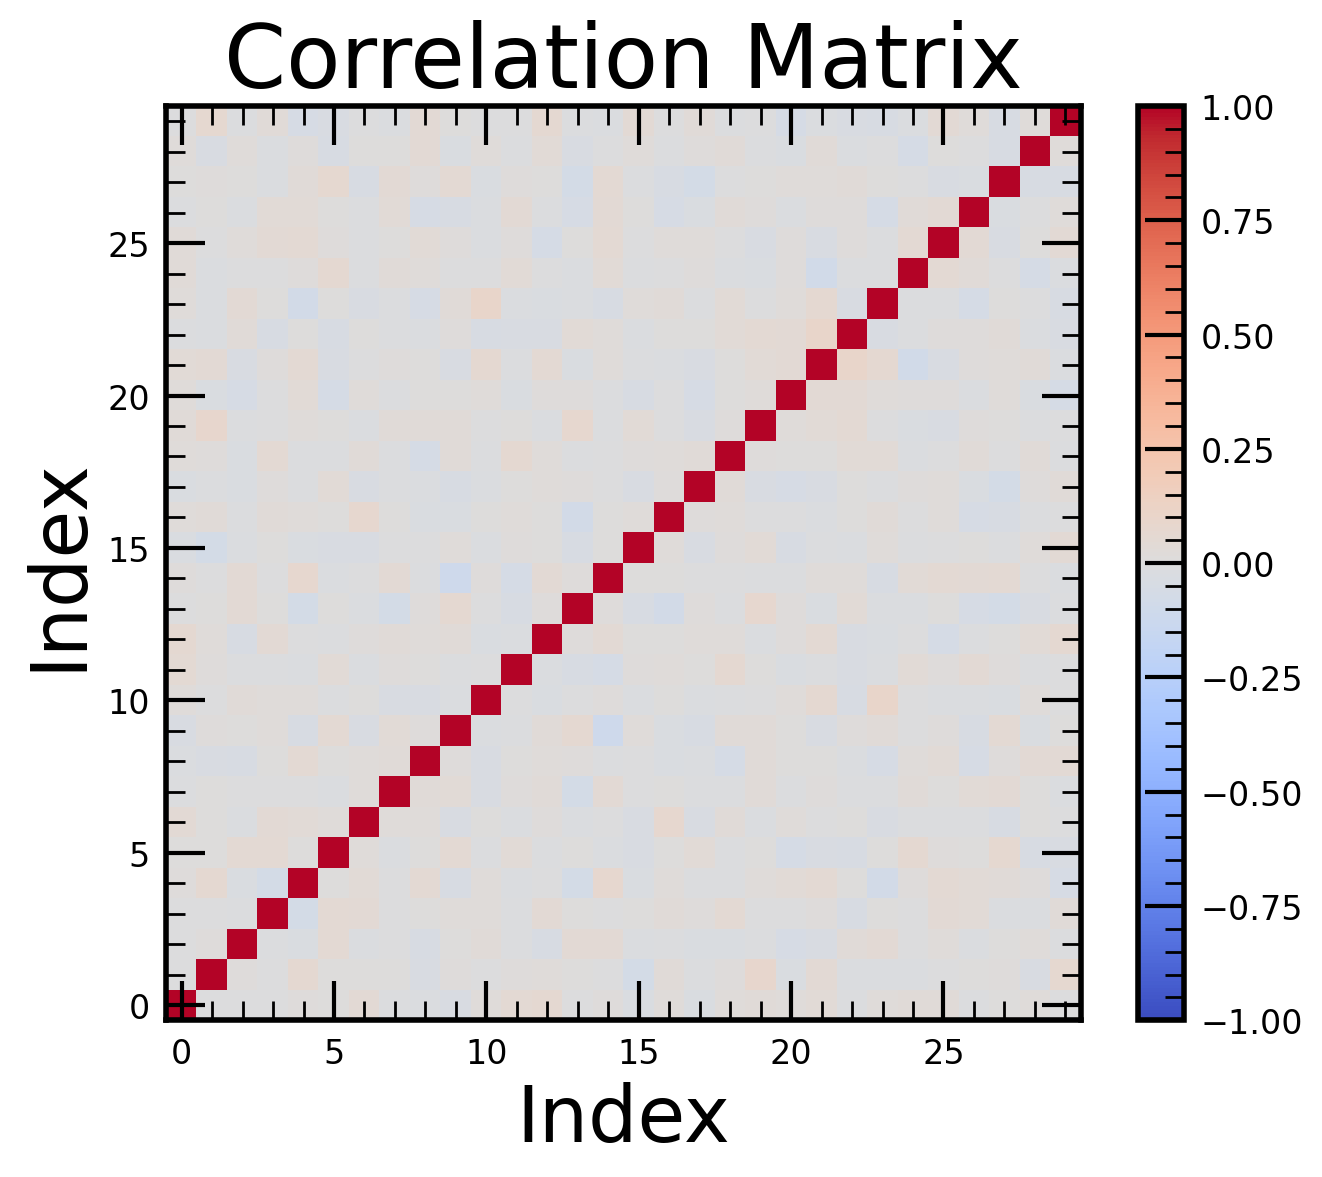

In [30]:
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_fid_emu, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal', origin='lower')
plt.title('Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Index')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### Emu, varying-parameter set:

In [31]:
data_mode = 'emu'
statistics = ['pk']

tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_errG = '_boxsize1000'
n_rlzs_per_cosmo = 1
tag_noiseless = ''
#tag_noiseless = '_noiseless' # if use noiseless, set evaluate_mean=False (?)
tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
kwargs_data = {'n_rlzs_per_cosmo': n_rlzs_per_cosmo,
                    'tag_errG': tag_errG,
                    'tag_datagen': tag_datagen,
                    'tag_noiseless': tag_noiseless}
    
tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [32]:
k_emu, y_emu, y_err_emu, idxs_params_emu, params_df_emu, param_dict_fixed_emu, biasparams_df_emu, biasparams_dict_fixed_emu, random_ints_cosmo_emu, random_ints_bias_emu = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=None, #doing this to not mask, dunno why need to mask so much...
                                    kwargs=kwargs_data)
k_emu, y_emu, y_err_emu = k_emu[0], y_emu[0], y_err_emu[0]

../data/emuPks/emuPks_p5_n10000_biaszen_p4_n10000/emuPks_noisy_boxsize1000_nrlzs1.npy
(10000, 30)
Loaded pk data with shape (10000, 30)
No tag_data provided, so not masking data


Text(0, 0.5, '$P(k)\\ [\\mathrm{Mpc}^3/h^3]$')

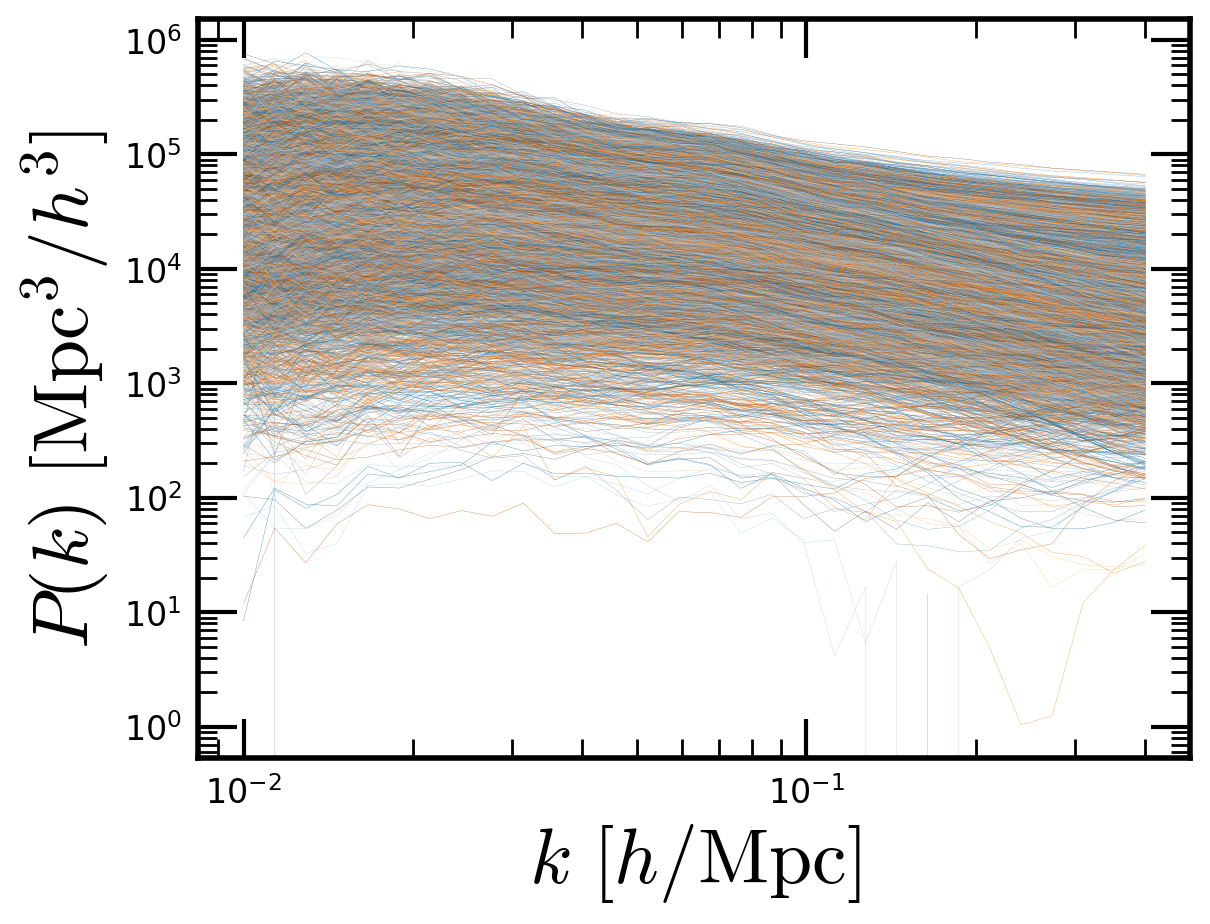

In [33]:
plt.loglog(k_emu, y_emu.T, lw=0.1)
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)\ [\mathrm{Mpc}^3/h^3]$')

In [34]:
theta_emu, param_names_emu = data_loader.param_dfs_to_theta(params_df_emu, biasparams_df_emu)
theta_fid_emu = [params_dict_cv_emu[param] for param in param_names_emu]
print(theta_emu.shape, param_names_emu)

(10000, 9) ['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


In [35]:
derivatives_emu = fit_derivatives_from_grid(
    parameters_array=theta_emu,
    spectra_array=y_emu,
    fiducial_params=theta_fid_emu,
    param_names=param_names_emu,
    extents=extents,
)
print("Derivatives shape:", {k: v.shape for k, v in derivatives_emu.items()})

omega_cold 37 [0.085]
sigma8_cold 27 [0.125]
hubble 35 [0.1]
omega_baryon 29 [0.01]
ns 37 [0.045]
b1 24 [1.5]
b2 45 [2.]
bs2 35 [2.]
bl 40 [10.]
Derivatives shape: {'omega_cold': (30,), 'sigma8_cold': (30,), 'hubble': (30,), 'omega_baryon': (30,), 'ns': (30,), 'b1': (30,), 'b2': (30,), 'bs2': (30,), 'bl': (30,)}


try also computing derivatives more directly bc we have emu 

In [36]:
dir_emus_lbias = '/home/kstoreyf/external' #hyperion path
emu, emu_bounds, emu_param_names_all = utils.load_emu(dir_emus_lbias=dir_emus_lbias)  

Loading l-bias lpt emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using ver

Nonlinear l-bias emulator loaded in memory.


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
def estimate_derivatives_emu_shift(emu, k, fiducial_cosmo_param_dict, fiducial_bias_param_dict, 
                                   param_names,
                                   deltas):
    derivatives = {}
    
    cosmo_params = fiducial_cosmo_param_dict.copy()
    for cosmo_param_name in fiducial_cosmo_param_dict:
        cosmo_param_name_emu = utils.param_name_to_param_name_emu(cosmo_param_name)
        cosmo_params[cosmo_param_name_emu] = fiducial_cosmo_param_dict[cosmo_param_name]
                
    expfactor = 1.0 # careful, may need to change at some point!
    cosmo_params['expfactor'] = expfactor
    
    for i, pn in enumerate(param_names):

        # Forward difference        
        bias_param_dict_plus = fiducial_bias_param_dict.copy()
        cosmo_param_dict_plus = cosmo_params.copy()
        if pn in bias_param_dict_plus:
            bias_param_dict_plus[pn] += deltas[i]
        elif pn in cosmo_param_dict_plus:
            cosmo_param_dict_plus[pn] += deltas[i]

        bias_params_plus = [bias_param_dict_plus[bn] for bn in utils.biasparam_names_ordered]
        _, pk_plus, _ = emu.get_galaxy_real_pk(bias=bias_params_plus, k=k, 
                                                **cosmo_param_dict_plus)    
        
        # Backward difference 
        bias_param_dict_minus = fiducial_bias_param_dict.copy()
        cosmo_param_dict_minus = cosmo_params.copy()
        if pn in bias_param_dict_minus:
            bias_param_dict_minus[pn] -= deltas[i]
        elif pn in cosmo_param_dict_minus:
            cosmo_param_dict_minus[pn] -= deltas[i]
        bias_params_minus = [bias_param_dict_minus[bn] for bn in utils.biasparam_names_ordered]
        _, pk_minus, _ = emu.get_galaxy_real_pk(bias=bias_params_minus, k=k, 
                                                **cosmo_param_dict_minus)   
        
         # Central difference
        deriv_abs = (pk_plus - pk_minus) / (2 * deltas[i])
        derivatives[pn] = deriv_abs

    return derivatives

In [ ]:
def get_emu_shift(emu, k, cosmo_param_dict_fid, bias_param_dict_fid, 
                                   param_names,
                                   deltas, n_deltas_per_side=2):
    
    # returns: []
    derivatives = {}
    
    cosmo_param_dict_emu_fid = cosmo_param_dict_fid.copy()
    for cosmo_param_name in cosmo_param_dict_fid:
        cosmo_param_name_emu = utils.param_name_to_param_name_emu(cosmo_param_name)
        cosmo_param_dict_emu_fid[cosmo_param_name_emu] = cosmo_param_dict_fid[cosmo_param_name]        
    expfactor = 1.0 # careful, may need to change at some point!
    cosmo_param_dict_emu_fid['expfactor'] = expfactor
        
    thetas, pks = [], []
    bias_params_fid = [bias_param_dict_fid[bn] for bn in utils.biasparam_names_ordered]
    _, pk_fid, _ = emu.get_galaxy_real_pk(bias=bias_params_fid, k=k, 
                                            **cosmo_param_dict_emu_fid)  
    theta = [cosmo_param_dict_emu_fid[pn] if pn in cosmo_param_dict_emu_fid else bias_param_dict_fid[pn] for pn in param_names]    
    thetas.append(theta)
    pks.append(pk_fid)
    
    for i, pn in enumerate(param_names):

        for nd in range(n_deltas_per_side):

            # Forward difference        
            bias_param_dict_plus = bias_params_fid.copy()
            cosmo_param_dict_plus = cosmo_param_dict_emu_fid.copy()
            if pn in bias_param_dict_plus:
                bias_param_dict_plus[pn] += nd*deltas[i]
            elif pn in cosmo_param_dict_plus:
                cosmo_param_dict_plus[pn] += nd*deltas[i]

            bias_params_plus = [bias_param_dict_plus[bn] for bn in utils.biasparam_names_ordered]
            _, pk_plus, _ = emu.get_galaxy_real_pk(bias=bias_params_plus, k=k, 
                                                    **cosmo_param_dict_plus)    
            theta = [cosmo_param_dict_plus[pn] if pn in cosmo_param_dict_plus else bias_param_dict_plus[pn] for pn in param_names]    
            thetas.append(theta)
            pks.append(pk_fid)
            
            # Backward difference 
            bias_param_dict_minus = bias_params_fid.copy()
            cosmo_param_dict_minus = cosmo_param_dict_emu_fid.copy()
            if pn in bias_param_dict_minus:
                bias_param_dict_minus[pn] -= nd*deltas[i]
            elif pn in cosmo_param_dict_minus:
                cosmo_param_dict_minus[pn] -= nd*deltas[i]
            bias_params_minus = [bias_param_dict_minus[bn] for bn in utils.biasparam_names_ordered]
            _, pk_minus, _ = emu.get_galaxy_real_pk(bias=bias_params_minus, k=k, 
                                                    **cosmo_param_dict_minus)   
        
         # Central difference
        deriv_abs = (pk_plus - pk_minus) / (2 * deltas[i])
        derivatives[pn] = deriv_abs

    return derivatives

In [ ]:
for i, pn in enumerate(param_names):
    plt.plot(thetas[:, i], pks, 'o', label=pn)

can't get this to work - issue with zero-valued bias params. maybe easiest to generate a test sample with nonzero bias params...

In [38]:
#deltas = [param_dict_fixed_cv_emu[pn] * 0.01 for pn in utils.cosmo_param_names_ordered]
#deltas.extend([0.01, 0.02, 0.02, 0.05])
deltas = [np.abs(np.diff(extents[pn])[0])/10 for pn in param_names]
print(deltas)
derivatives_emu_shift = estimate_derivatives_emu_shift(emu, k_cv_emu,
                                                       param_dict_fixed_cv_emu, biasparams_dict_fixed_cv_emu,
                                                       param_names,
                                                       deltas=deltas)
print("Derivatives shift shape:", {k: v.shape for k, v in derivatives_emu_shift.items()})

[0.017, 0.025, 0.020000000000000007, 0.0019999999999999996, 0.008999999999999998, 0.3, 0.4, 0.4, 2.0]
Derivatives shift shape: {'omega_cold': (30,), 'sigma8_cold': (30,), 'hubble': (30,), 'omega_baryon': (30,), 'ns': (30,), 'b1': (30,), 'b2': (30,), 'bs2': (30,), 'bl': (30,)}


In [39]:
fisher_matrix_emu = compute_fisher_matrix(derivatives_emu, cov_fid_emu, param_names)
cov_fisher_emu = np.linalg.inv(fisher_matrix_emu)
print("Fisher matrix shape:", fisher_matrix_emu.shape)

Fisher matrix shape: (9, 9)


In [40]:
fisher_matrix_emu_shift = compute_fisher_matrix(derivatives_emu_shift, cov_fid_emu, param_names)
cov_fisher_emu_shift = np.linalg.inv(fisher_matrix_emu_shift)
print("Fisher matrix shape:", fisher_matrix_emu_shift.shape)

Fisher matrix shape: (9, 9)


In [41]:
n_samples = 10000
samples_emu = np.random.multivariate_normal(theta_fid, cov_fisher_emu, size=n_samples)

In [42]:
n_samples = 10000
samples_emu_shift = np.random.multivariate_normal(theta_fid, cov_fisher_emu_shift, size=n_samples)

In [43]:
# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
extents = {**dict_bounds_cosmo, **dict_bounds_bias}

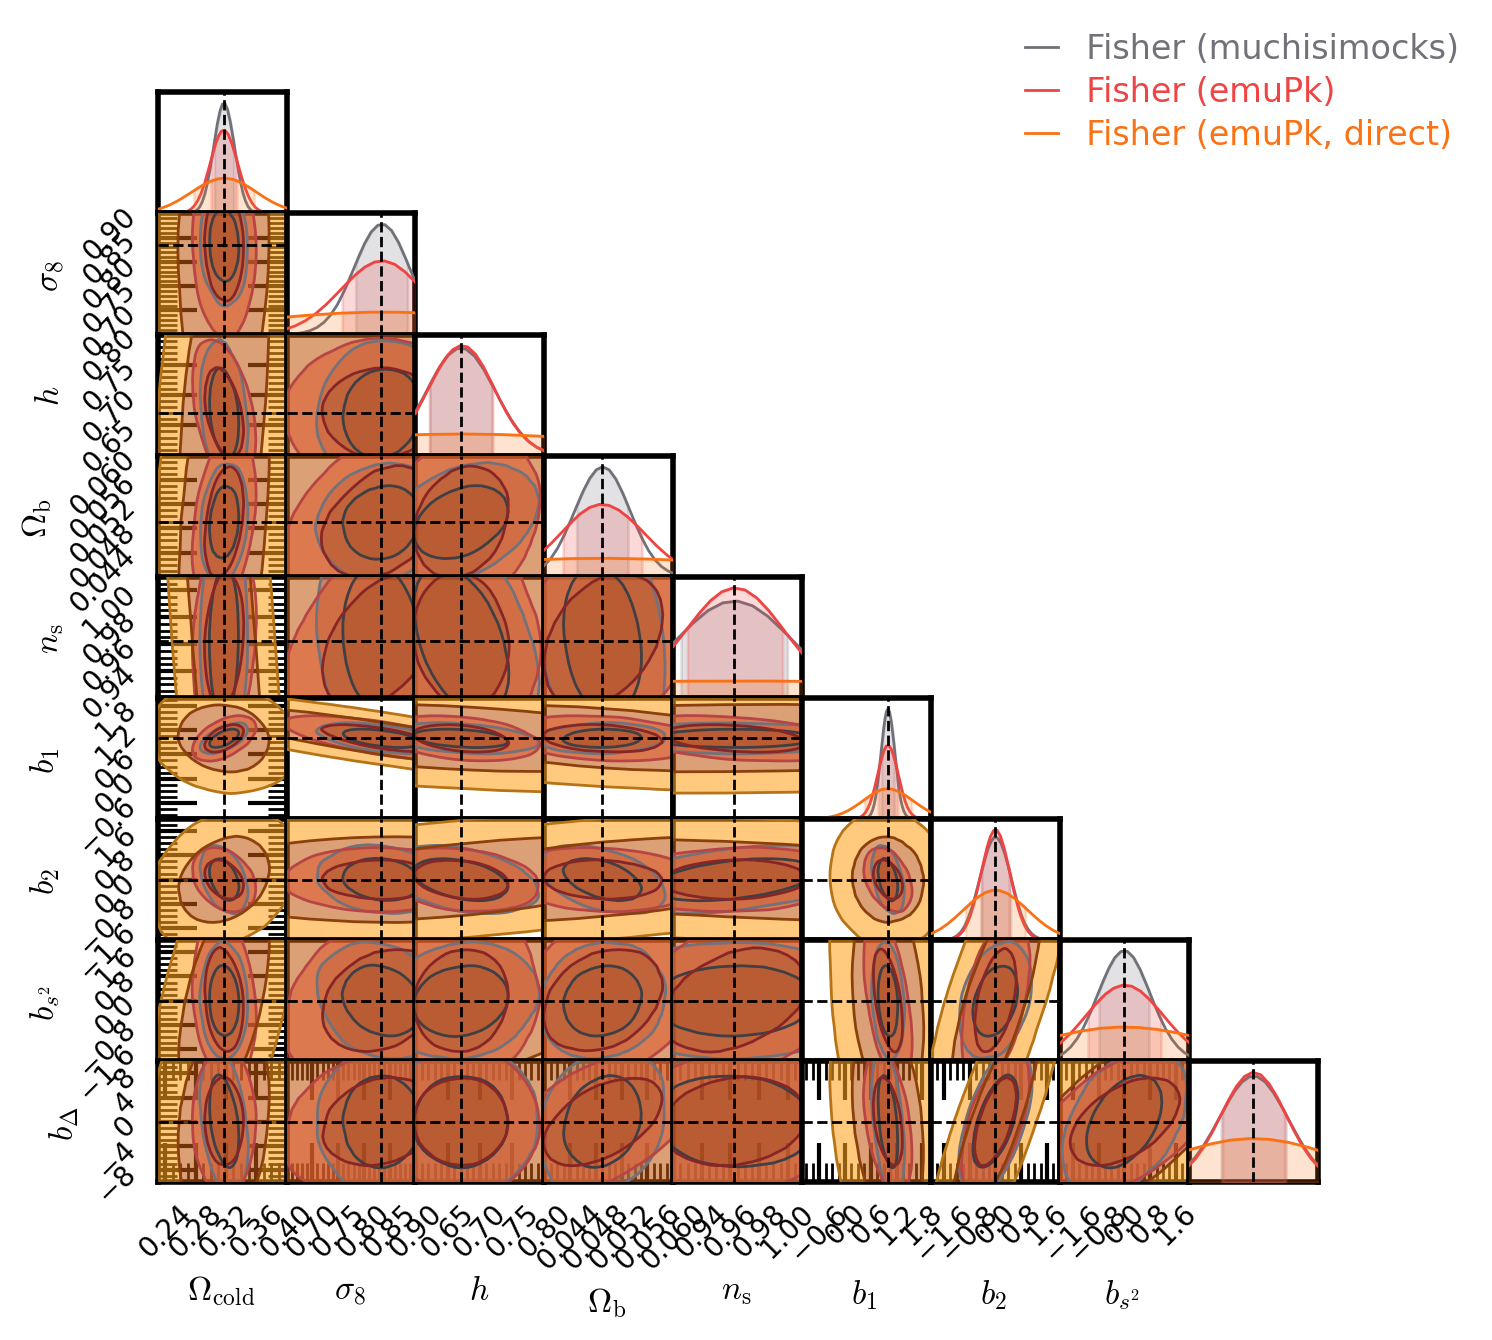

In [44]:

# samples_arr = [samples, samples_emu]#, samples_emu_shift]
# labels = ['Fisher (muchisimocks)', 'Fisher (emuPk)']#, 'Fisher (emuPk, direct)']
# colors = ['gray', 'red']#, 'orange']

samples_arr = [samples, samples_emu, samples_emu_shift]
labels = ['Fisher (muchisimocks)', 'Fisher (emuPk)', 'Fisher (emuPk, direct)']
colors = ['gray', 'red', 'orange']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, param_names, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

Save fisher matrices and samples

In [45]:
tag_stats = f'_{"_".join(statistics)}'
# let's just save one per data mode and stats now    
tag_data = '_'+data_mode + tag_stats
tag_inf = tag_data
tag_test = '' #?

#tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
#tag_test = tag_data #?
print(tag_inf)
    
dir_fisher = f'../results/results_fisher/fisher{tag_inf}'
Path.mkdir(Path(dir_fisher), parents=True, exist_ok=True)
        
fn_samples_test_pred = f'{dir_fisher}/samples_test{tag_test}_pred.npy'
np.save(fn_samples_test_pred, samples_emu)

fn_fishmat = f'{dir_fisher}/fisher_matrix.npy'
np.save(fn_fishmat, fisher_matrix)

fn_theta_fid = f'{dir_fisher}/theta_fid.npy'
np.save(fn_theta_fid, theta_fid)

fn_param_names = f'{dir_fisher}/param_names.txt'
np.savetxt(fn_param_names, param_names, fmt='%s')

_emu_pk


In [46]:
# TODO: save shifted/direct version, if get to work

## Compare covariances

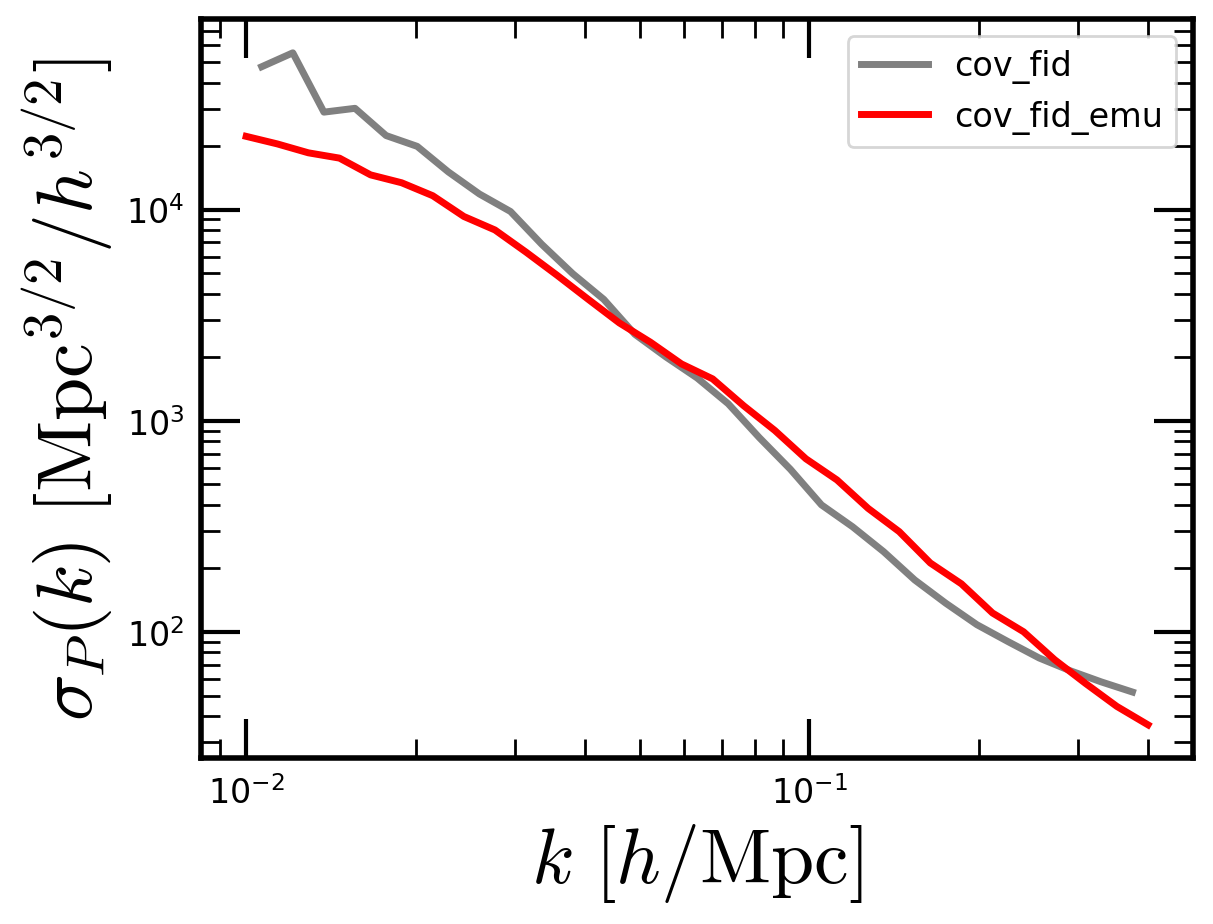

In [47]:

plt.plot(k_cv, np.sqrt(np.diag(cov_fid)), label='cov_fid', color='gray')
plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\sigma_P(k)\ [\mathrm{Mpc}^{3/2}/h^{3/2}]$')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)


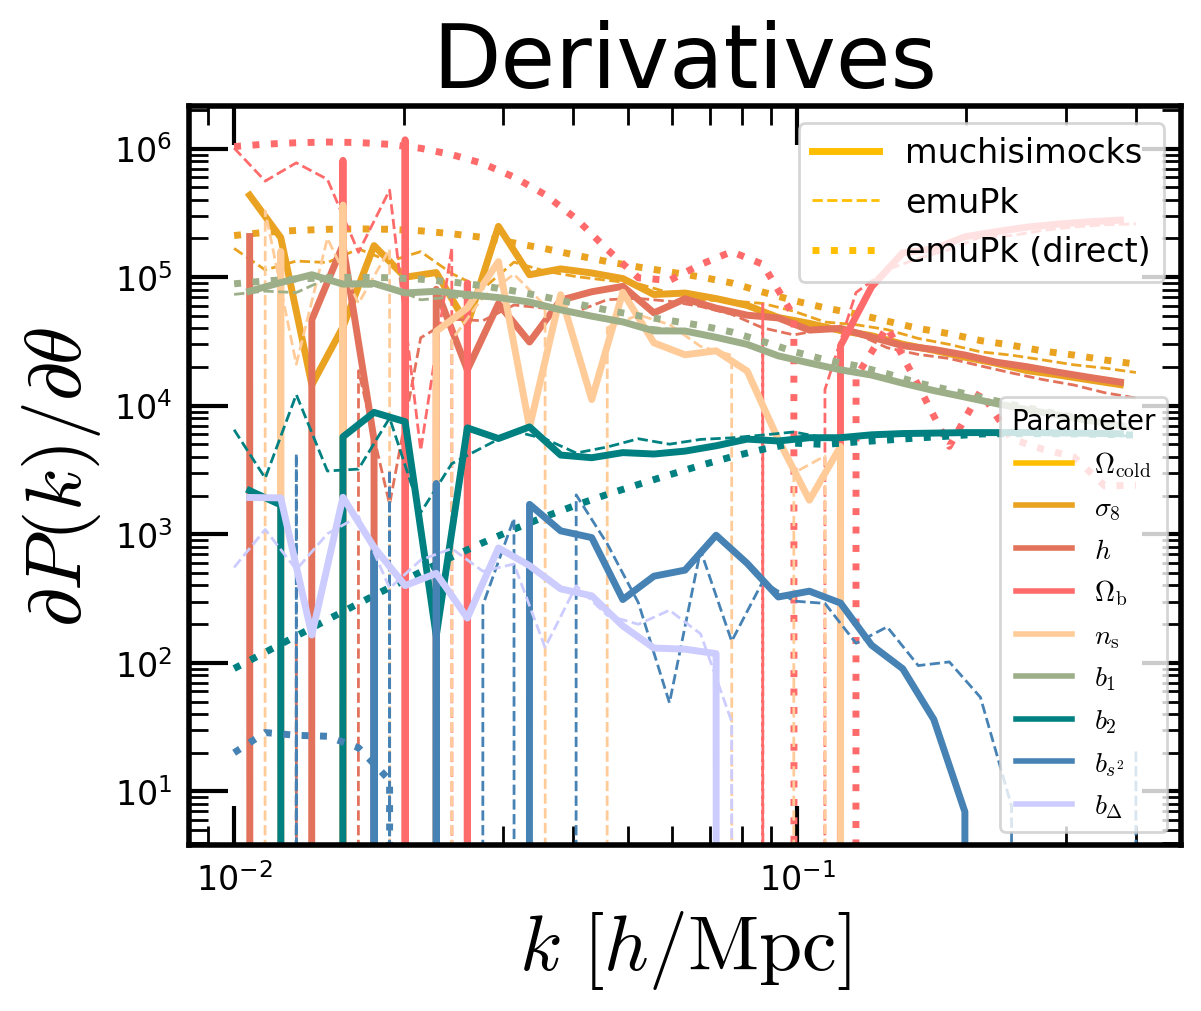

In [48]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks'
        label_emuPk = 'emuPk'
        label_emuPk_shift = 'emuPk (direct)'
    else:
        label_muchisimocks = None
        label_emuPk = None
        label_emuPk_shift = None

    plt.plot(k, derivatives[param_name], label=label_muchisimocks, color=colors_params[i])
    plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=12, loc='upper right')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names[i]]) for i in range(len(param_names))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='lower right', fontsize=10)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('log')

## compare to SBI 

['_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain10000_best-sbi-rand10', '_muchisimocks_pk']
fn_samples = ../results/results_sbi/sbi_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain10000_best-sbi-rand10/samples_test_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
(10000, 1, 9)
fn_samples = ../results/results_fisher/fisher_muchisimocks_pk/samples_test_pred.npy
(10000, 9)


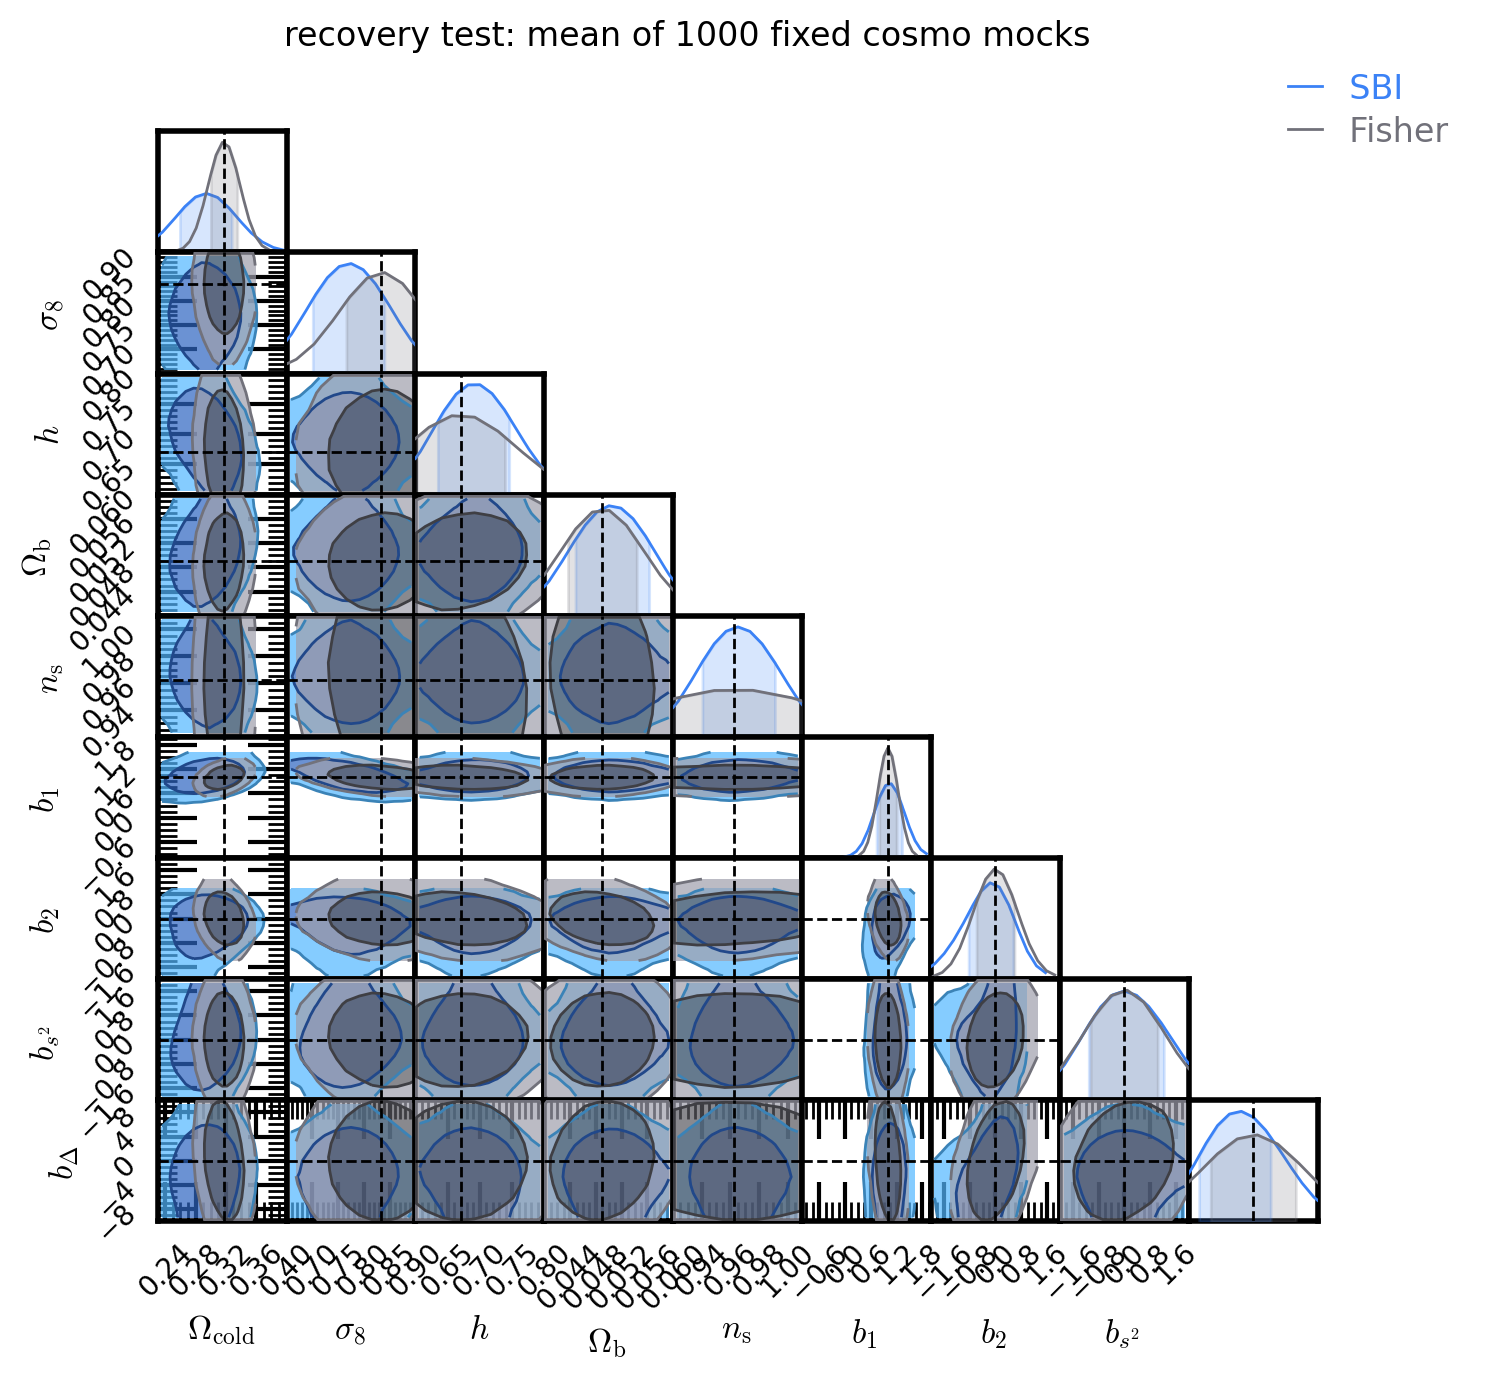

In [49]:
n_train = 10000
tag_biasparams_x10 = '_biaszen_p4_n10000'

inf_methods = [
               'sbi',
               'fisher'
              ]
tags_inf = [
            f'_muchisimocksPk{tag_params}{tag_biasparams}_ntrain{n_train}_best-sbi-rand10',
            '_muchisimocks_pk'
            ]
tags_test = [
             #f'{tag_data_test_fixed}_mean',
             '_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean',
             ''
            ]
labels_extra = [
                '',
                '',
                ]
title = 'recovery test: mean of 1000 fixed cosmo mocks'
colors = ['blue', 'gray']

print(tags_inf)
param_names_vary = param_names
idx_obs = 0
plotter.plot_contours_inf(param_names_vary, idx_obs, theta_fid, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels_extra=labels_extra,
                        title=title, extents=extents)

## Load in fisher muchisimocks set

In [5]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params = '_fisher_quijote'
tag_biasparams = '_b1000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [6]:
k, y, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, random_ints_cosmo, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k, y, y_err = k[0], y[0], y_err[0]
print(y.shape)
print(k.shape)

Loading muchisimocks data
_b1000_p0_n1
Found 21 pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_fisher_quijote
dir statistics /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_fisher_quijote
Loaded pk data with shape (21, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt (already exists)
Masked 1 out of 30 bins
(21, 29)
(29,)


In [103]:
def compute_derivatives_from_fisherset(params_df, pk_array, param_names,
                                       n_deltas_for_diff=1):
    """
    Compute derivatives of the power spectra using finite differences from the _fisher_quijote set.
    Assumes params_df has columns 'changed_param' and 'n_delta', and pk_array is aligned row-wise.
    Uses n_delta = 2 and n_delta = -2 for each parameter.

    Returns:
        derivatives: dict of {param_name: derivative array (same shape as pk)}
    """
    derivatives = {}
    for param in param_names:
        # Find indices for n_delta = n_deltas_for_dif and n_delta = -n_deltas_for_diff for this parameter
        idx_plus = params_df[(params_df['param_shifted'] == param) & (params_df['n_deltas'] == n_deltas_for_diff)].index
        idx_minus = params_df[(params_df['param_shifted'] == param) & (params_df['n_deltas'] == -n_deltas_for_diff)].index
        if len(idx_plus) == 0 or len(idx_minus) == 0:
            raise ValueError(f"Missing n_delta=2 or n_delta=-2 for parameter {param}")
        pk_plus = pk_array[idx_plus[0]]
        pk_minus = pk_array[idx_minus[0]]
        delta_tot = params_df.loc[idx_plus[0], param] - params_df.loc[idx_minus[0], param]
        derivatives[param] = (pk_plus - pk_minus) / delta_tot
    return derivatives

In [8]:
derivatives_shift_nd1 = compute_derivatives_from_fisherset(params_df, y, 
                        utils.cosmo_param_names_ordered, n_deltas_for_diff=1)

omega_cold
sigma8_cold
hubble
omega_baryon
ns


In [9]:
derivatives_shift_nd2 = compute_derivatives_from_fisherset(params_df, y, 
                        utils.cosmo_param_names_ordered, n_deltas_for_diff=2)

omega_cold
sigma8_cold
hubble
omega_baryon
ns


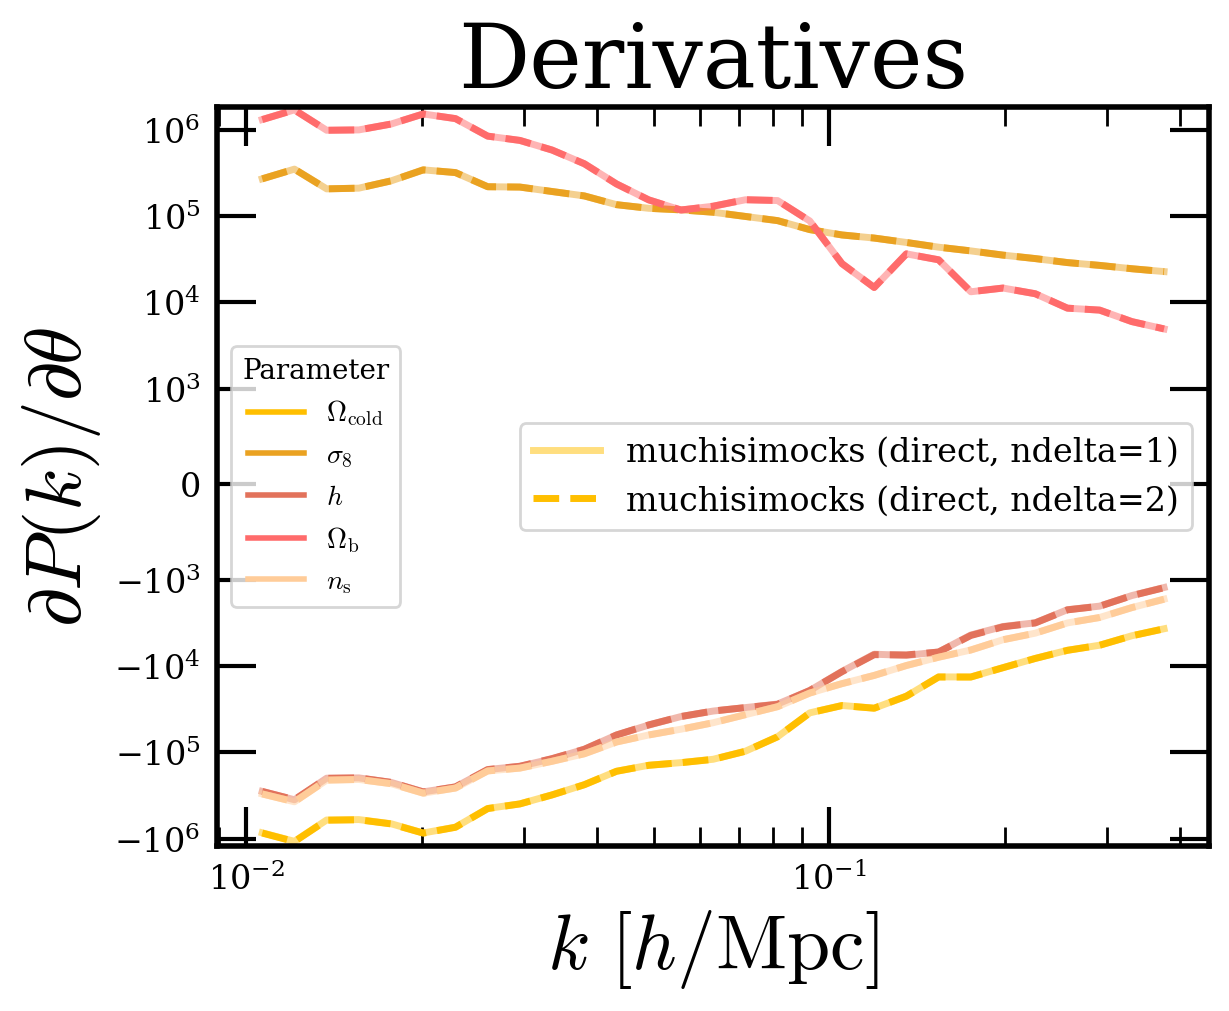

In [11]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.cosmo_param_names_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_muchisimocks2 = 'muchisimocks (direct, ndelta=2)'
    else:
        label_muchisimocks = None
        label_muchisimocks2 = None

    plt.plot(k, derivatives_shift_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(k, derivatives_shift_nd2[param_name], label=label_muchisimocks2, color=colors_params[i], ls='--')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=12, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=10)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

In [24]:
fisher_matrix_shift_nd1 = compute_fisher_matrix(derivatives_shift_nd1, cov_fid, param_names_show)
cov_fisher_shift_nd1 = np.linalg.inv(fisher_matrix_shift_nd1)
print("Fisher matrix shape:", fisher_matrix_shift_nd1.shape)

Fisher matrix shape: (5, 5)


In [25]:
fisher_matrix_shift_nd2 = compute_fisher_matrix(derivatives_shift_nd2, cov_fid, param_names_show)
cov_fisher_shift_nd2 = np.linalg.inv(fisher_matrix_shift_nd2)
print("Fisher matrix shape:", fisher_matrix_shift_nd2.shape)

Fisher matrix shape: (5, 5)


In [34]:
n_samples = 10000
samples_shift_nd1 = np.random.multivariate_normal(theta_fid[:len(param_names_show)], cov_fisher_shift_nd1, size=n_samples)

In [35]:
n_samples = 10000
samples_shift_nd2 = np.random.multivariate_normal(theta_fid[:len(param_names_show)], cov_fisher_shift_nd2, size=n_samples)

In [36]:
params_dict = params_df.iloc[0].to_dict()
params_dict.pop('param_shifted')
params_dict.pop('n_deltas')
#params_dict_cv.update(biasparams_dict_fixed_cv)
#print(params_dict_cv)

0

In [39]:
# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo('_p5_n10000')
_, dict_bounds_bias, _ = genp.define_LH_bias('_biaszen_p4_n10000')
extents = {**dict_bounds_cosmo, **dict_bounds_bias}
print(extents)

{'omega_cold': [0.23, 0.4], 'omega_baryon': [0.04, 0.06], 'sigma8_cold': [0.65, 0.9], 'ns': [0.92, 1.01], 'hubble': [0.6, 0.8], 'neutrino_mass': [0.0, 0.4], 'w0': [-1.15, -0.85], 'wa': [-0.3, 0.3], 'b1': [-1, 2], 'b2': [-2, 2], 'bs2': [-2, 2], 'bl': [-10, 10]}


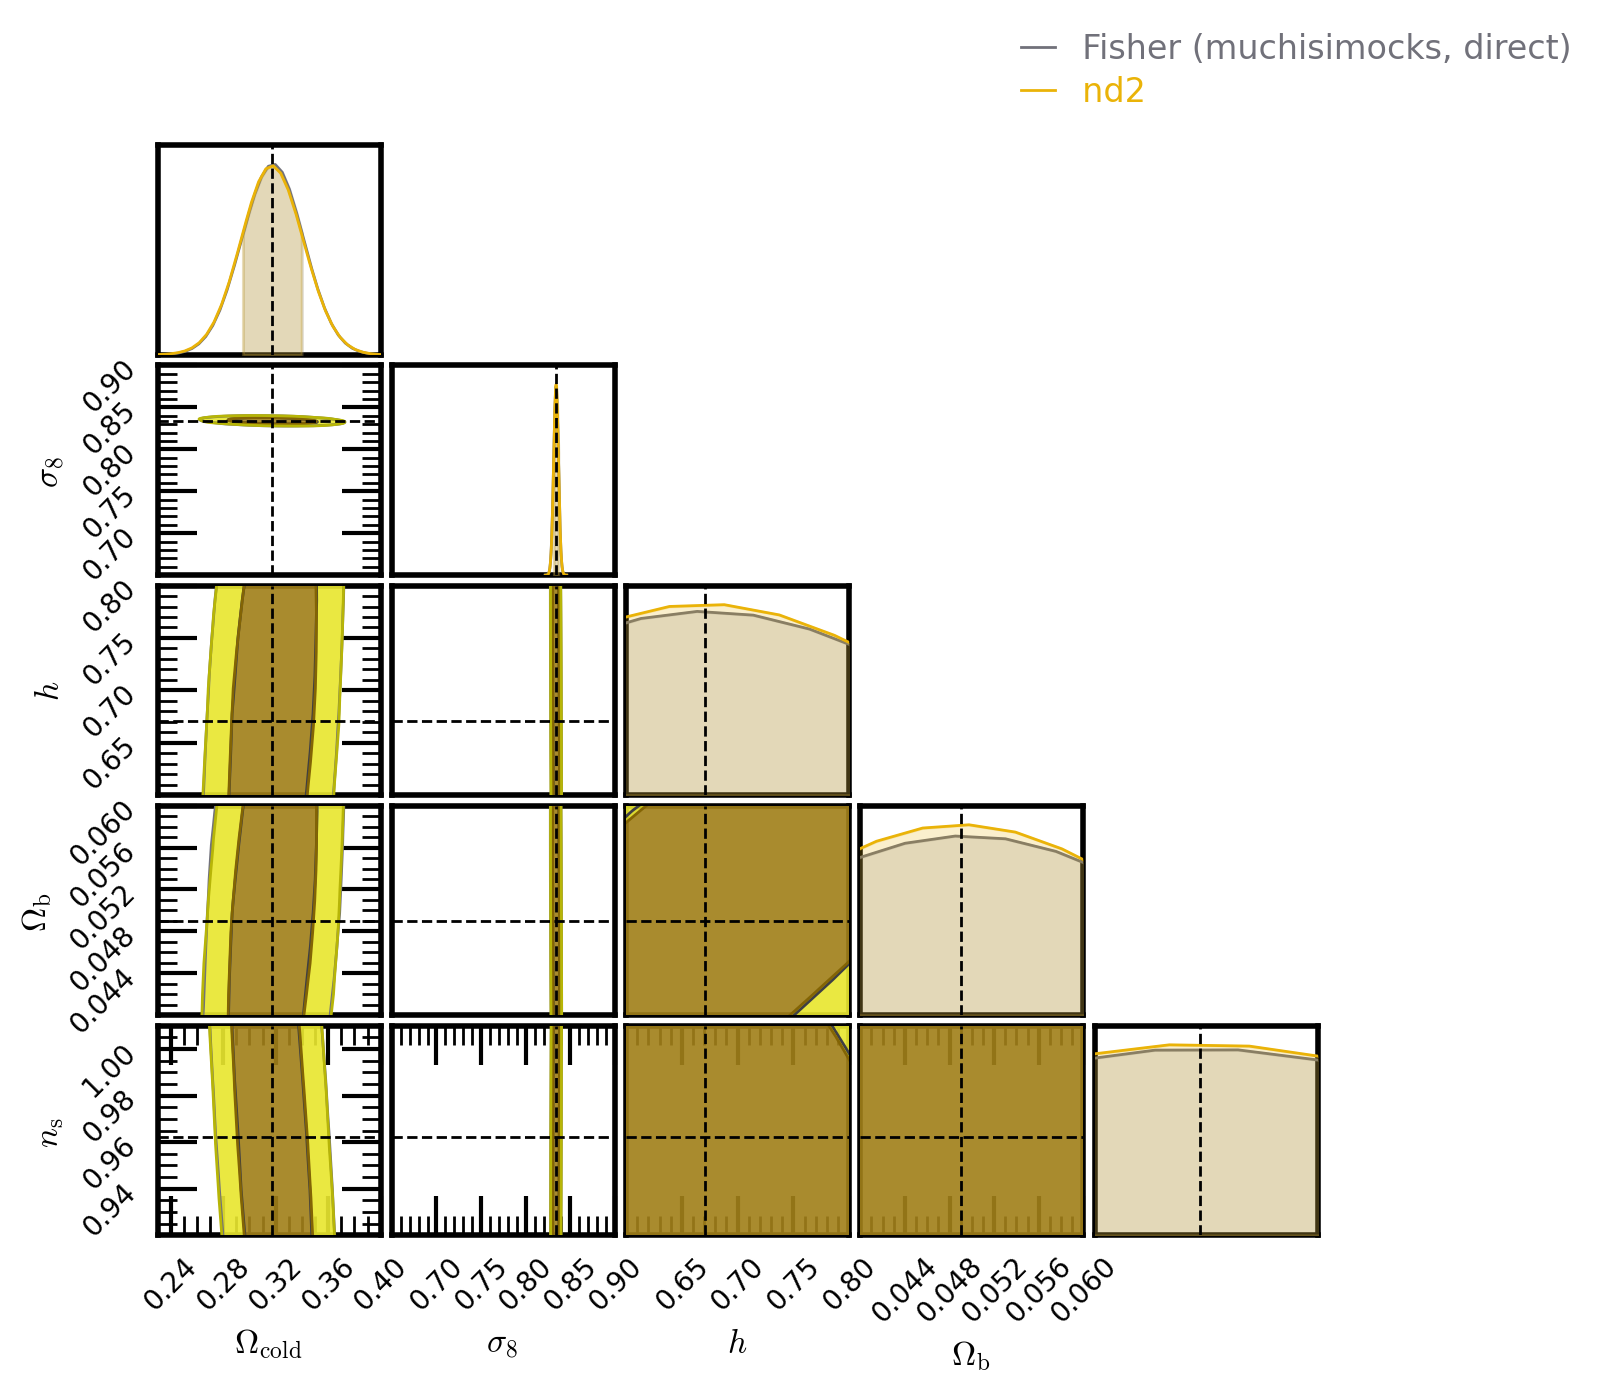

In [40]:

samples_arr = [samples_shift_nd1, samples_shift_nd2]
labels = ['Fisher (muchisimocks, direct)', 'nd2']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, param_names_show, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

Now with free bias params:

In [43]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params = '_fisher_quijote'
tag_biasparams_biaszen = '_fisher_biaszen'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data_biaszen = '_'+data_mode + tag_stats + tag_params + tag_biasparams_biaszen + tag_datagen

In [49]:
k_biaszen, y_biaszen, y_err_biaszen, idxs_params_biaszen, params_df_biaszen, param_dict_fixed_biaszen, biasparams_df_biaszen, biasparams_dict_fixed_biaszen, random_ints_cosmo_biaszen, random_ints_bias_biaszen = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams_biaszen,
                                    tag_data=tag_data_biaszen,
                                    kwargs=kwargs_data)
k_biaszen, y_biaszen, y_err_biaszen = k_biaszen[0], y_biaszen[0], y_err_biaszen[0]
print(k_biaszen.shape)
print(y_biaszen.shape)

Loading muchisimocks data
_fisher_biaszen
Found 21 pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_fisher_quijote
dir statistics /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_fisher_quijote
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0)]
Loaded pk data with shape (37, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_fisher_quijote_fisher_biaszen.txt
Loading from ../data/masks/mask_muchisimocks_pk_fisher_quijote_fisher_biaszen.txt (already exists)
Masked 1 out of 30 bins
(29,)
(37, 29)


In [63]:
def combine_fisher_param_dfs(params_df, biasparams_df):
    """
    Combine cosmological and bias parameter DataFrames for Fisher analysis.
    For every non-fiducial row in params_df, combine with fiducial biasparams_df.
    For every non-fiducial row in biasparams_df, combine with fiducial params_df.
    The fiducial row is where 'param_shifted' == 'fiducial'.
    Adds columns 'idx_cosmo', 'idx_bias', 'param_shifted', and 'n_deltas' for the original indices and meta info.
    Returns a DataFrame where each row is the fiducial with only one parameter varied.
    """
    # Identify fiducial rows
    fiducial_params_row = params_df[params_df['param_shifted'] == 'fiducial'].iloc[0]
    fiducial_bias_row = biasparams_df[biasparams_df['param_shifted'] == 'fiducial'].iloc[0]

    # Get parameter names (excluding meta columns)
    param_cols = [c for c in params_df.columns if c not in ['param_shifted', 'n_deltas']]
    bias_cols = [c for c in biasparams_df.columns if c not in ['param_shifted', 'n_deltas']]

    # Start with the all-fiducial row
    rows = []
    fiducial_row = {**fiducial_params_row[param_cols].to_dict(), **fiducial_bias_row[bias_cols].to_dict()}
    fiducial_row['idx_cosmo'] = fiducial_params_row.name
    fiducial_row['idx_bias'] = fiducial_bias_row.name
    fiducial_row['param_shifted'] = 'fiducial'
    fiducial_row['n_deltas'] = 0
    rows.append(fiducial_row.copy())

    # For every non-fiducial row in params_df, combine with fiducial biasparams
    for idx, row in params_df[params_df['param_shifted'] != 'fiducial'].iterrows():
        combined = {**row[param_cols].to_dict(), **fiducial_bias_row[bias_cols].to_dict()}
        combined['idx_cosmo'] = idx
        combined['idx_bias'] = fiducial_bias_row.name
        combined['param_shifted'] = row['param_shifted']
        combined['n_deltas'] = row['n_deltas']
        rows.append(combined)

    # For every non-fiducial row in biasparams_df, combine with fiducial params
    for idx, row in biasparams_df[biasparams_df['param_shifted'] != 'fiducial'].iterrows():
        combined = {**fiducial_params_row[param_cols].to_dict(), **row[bias_cols].to_dict()}
        combined['idx_cosmo'] = fiducial_params_row.name
        combined['idx_bias'] = idx
        combined['param_shifted'] = row['param_shifted']
        combined['n_deltas'] = row['n_deltas']
        rows.append(combined)

    all_param_names = param_cols + bias_cols + ['idx_cosmo', 'idx_bias', 'param_shifted', 'n_deltas']
    combined_df = pd.DataFrame(rows, columns=all_param_names)
    return combined_df

In [64]:
params_all_df = combine_fisher_param_dfs(params_df, biasparams_df_biaszen)
print(len(params_df), len(biasparams_df_biaszen), len(params_all_df))

21 17 37


In [ ]:
## need to ensure that the ys are aligned with the params

# Convert both to 2D integer arrays
idxs_params_biaszen = np.array(idxs_params_biaszen)
idxs_params_ordered = params_all_df[['idx_cosmo', 'idx_bias']].values

# Find the matching indices for each ordered pair
matching_indices = [np.where((idxs_params_biaszen == row).all(axis=1))[0][0] for row in idxs_params_ordered]
y_biaszen_ordered = y_biaszen[matching_indices]
print(y_biaszen_ordered.shape)

(37, 29)


In [104]:
derivatives_shift_biaszen_nd1 = compute_derivatives_from_fisherset(params_all_df, y_biaszen_ordered, 
                        utils.param_names_all_ordered, n_deltas_for_diff=1)

In [105]:
derivatives_shift_biaszen_nd2 = compute_derivatives_from_fisherset(params_all_df, y_biaszen_ordered, 
                        utils.param_names_all_ordered, n_deltas_for_diff=2)

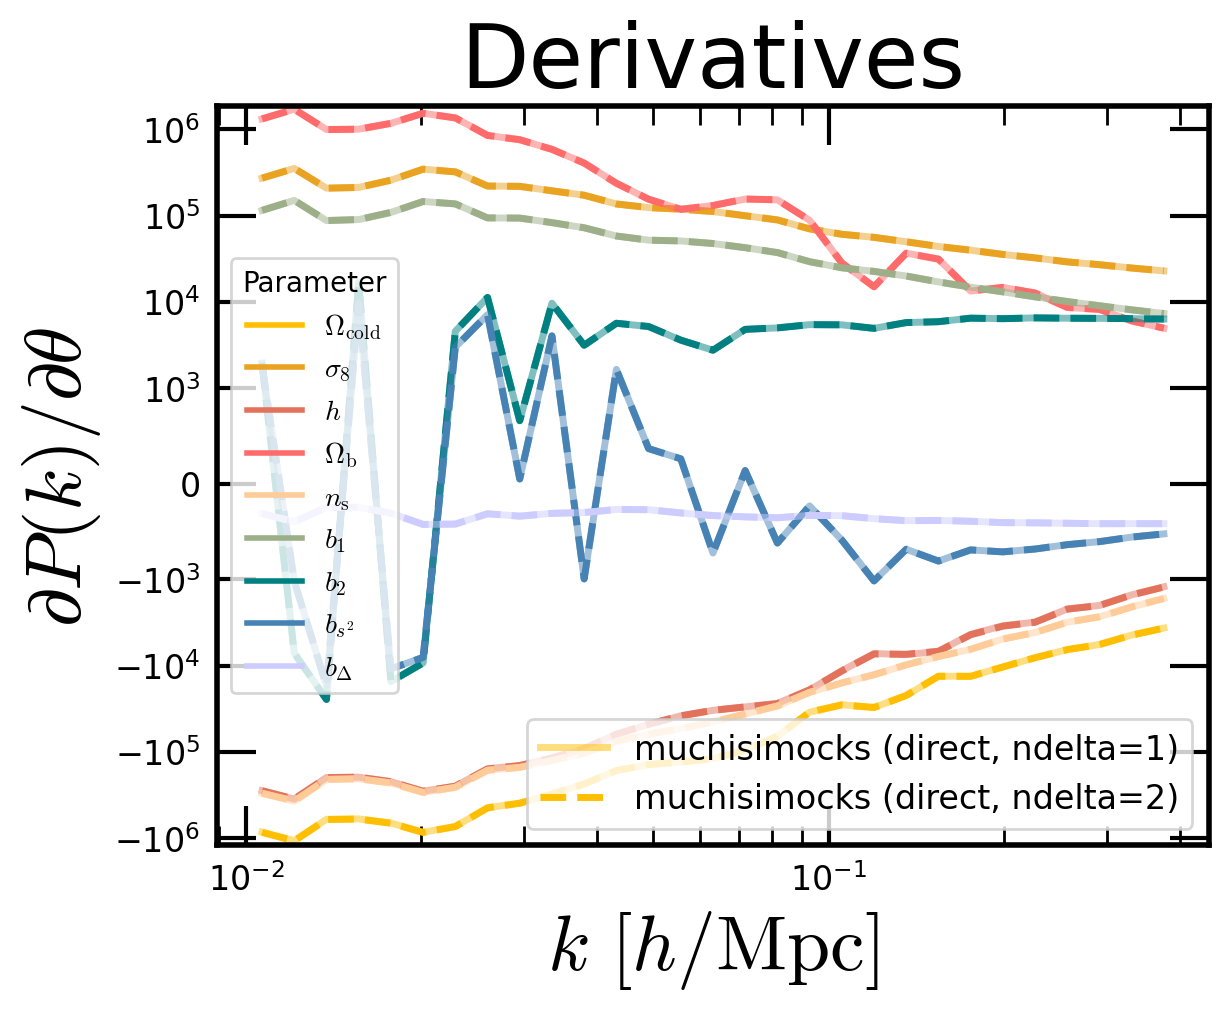

In [106]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.param_names_all_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_muchisimocks2 = 'muchisimocks (direct, ndelta=2)'
    else:
        label_muchisimocks = None
        label_muchisimocks2 = None

    plt.plot(k_biaszen, derivatives_shift_biaszen_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(k_biaszen, derivatives_shift_biaszen_nd2[param_name], label=label_muchisimocks2, color=colors_params[i], ls='--')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=12, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=10)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

In [100]:
fisher_matrix_shift_biaszen_nd1 = compute_fisher_matrix(derivatives_shift_biaszen_nd1, cov_fid, utils.param_names_all_ordered)
cov_fisher_shift_biaszen_nd1 = np.linalg.inv(fisher_matrix_shift_biaszen_nd1)
print("Fisher matrix shape:", fisher_matrix_shift_biaszen_nd1.shape)

Fisher matrix shape: (9, 9)


In [107]:
fisher_matrix_shift_biaszen_nd2 = compute_fisher_matrix(derivatives_shift_biaszen_nd2, cov_fid, utils.param_names_all_ordered)
cov_fisher_shift_biaszen_nd2 = np.linalg.inv(fisher_matrix_shift_biaszen_nd2)
print("Fisher matrix shape:", fisher_matrix_shift_biaszen_nd2.shape)

Fisher matrix shape: (9, 9)


In [ ]:
n_samples = 10000
samples_shift_biaszen_nd1 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_nd1, size=n_samples)

In [108]:
n_samples = 10000
samples_shift_biaszen_nd2 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_nd2, size=n_samples)

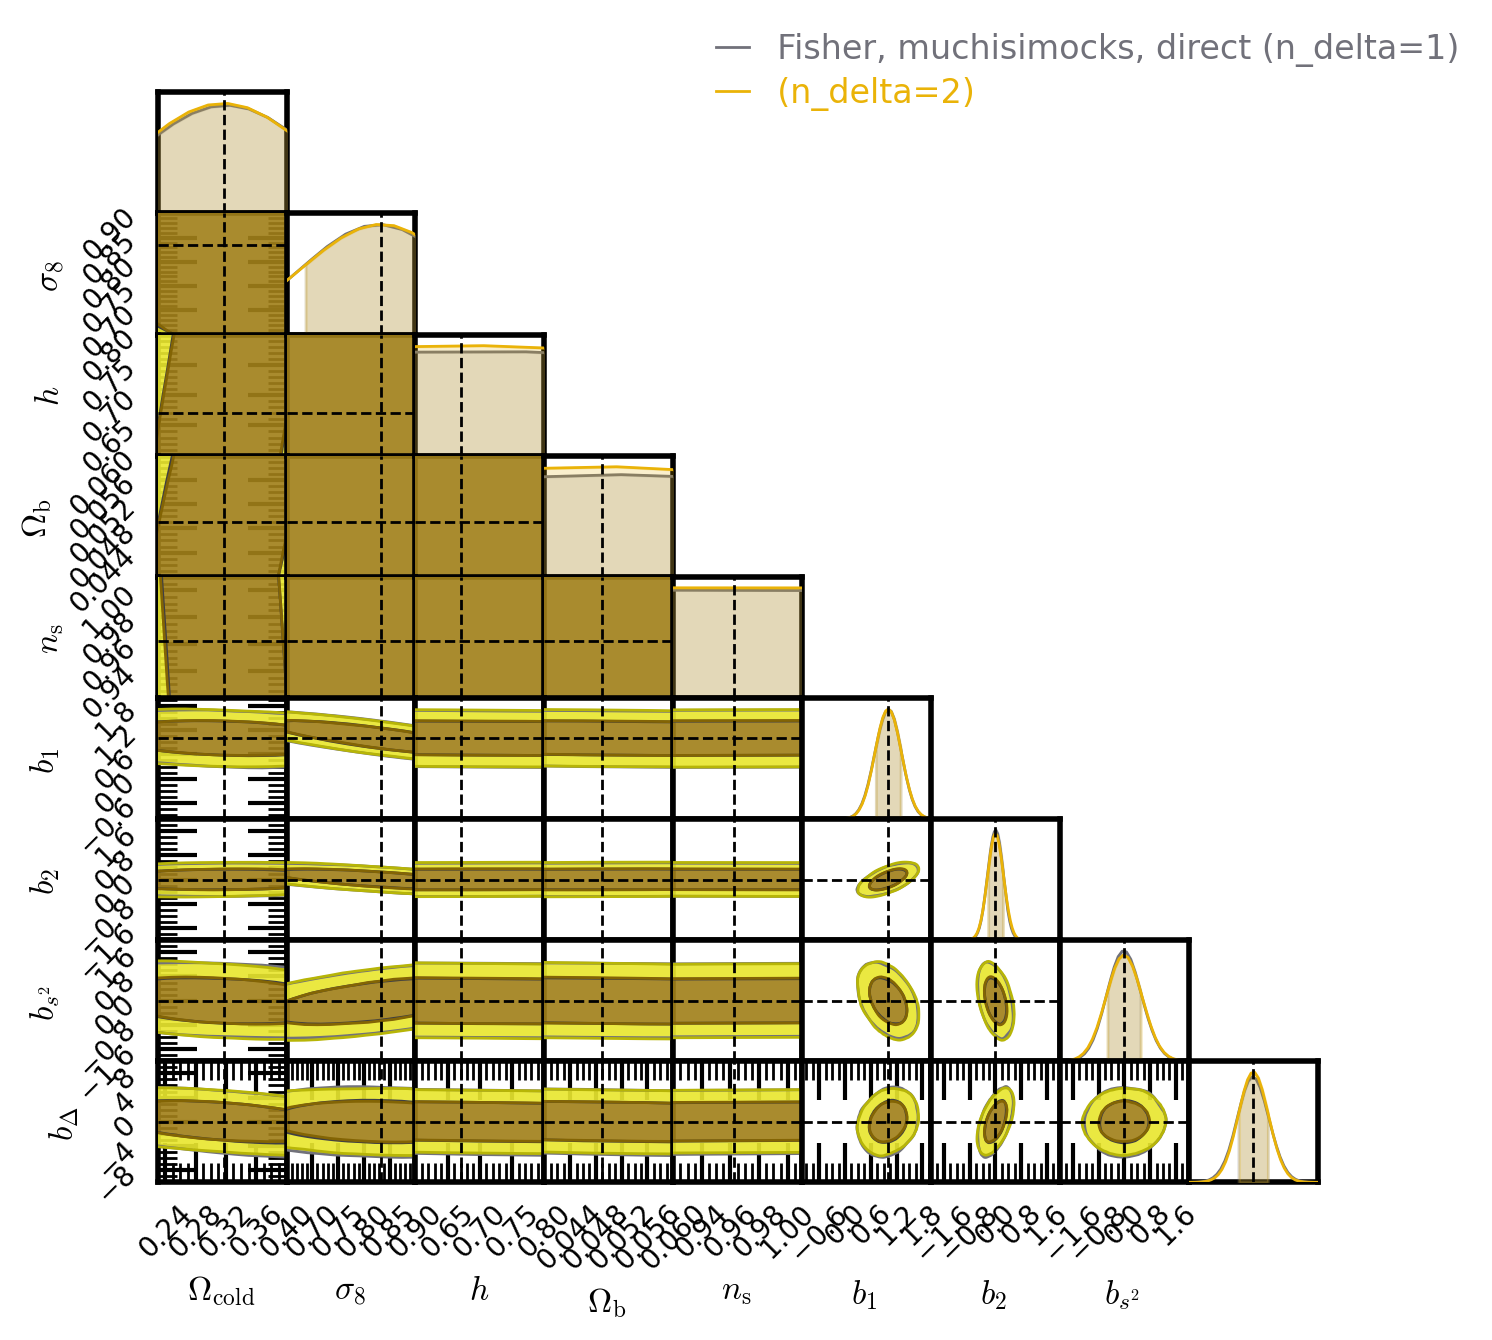

In [ ]:

samples_arr = [samples_shift_biaszen_nd1, samples_shift_biaszen_nd2]
labels = ['Fisher, muchisimocks, direct (n_delta=1)', '(n_delta=2)']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

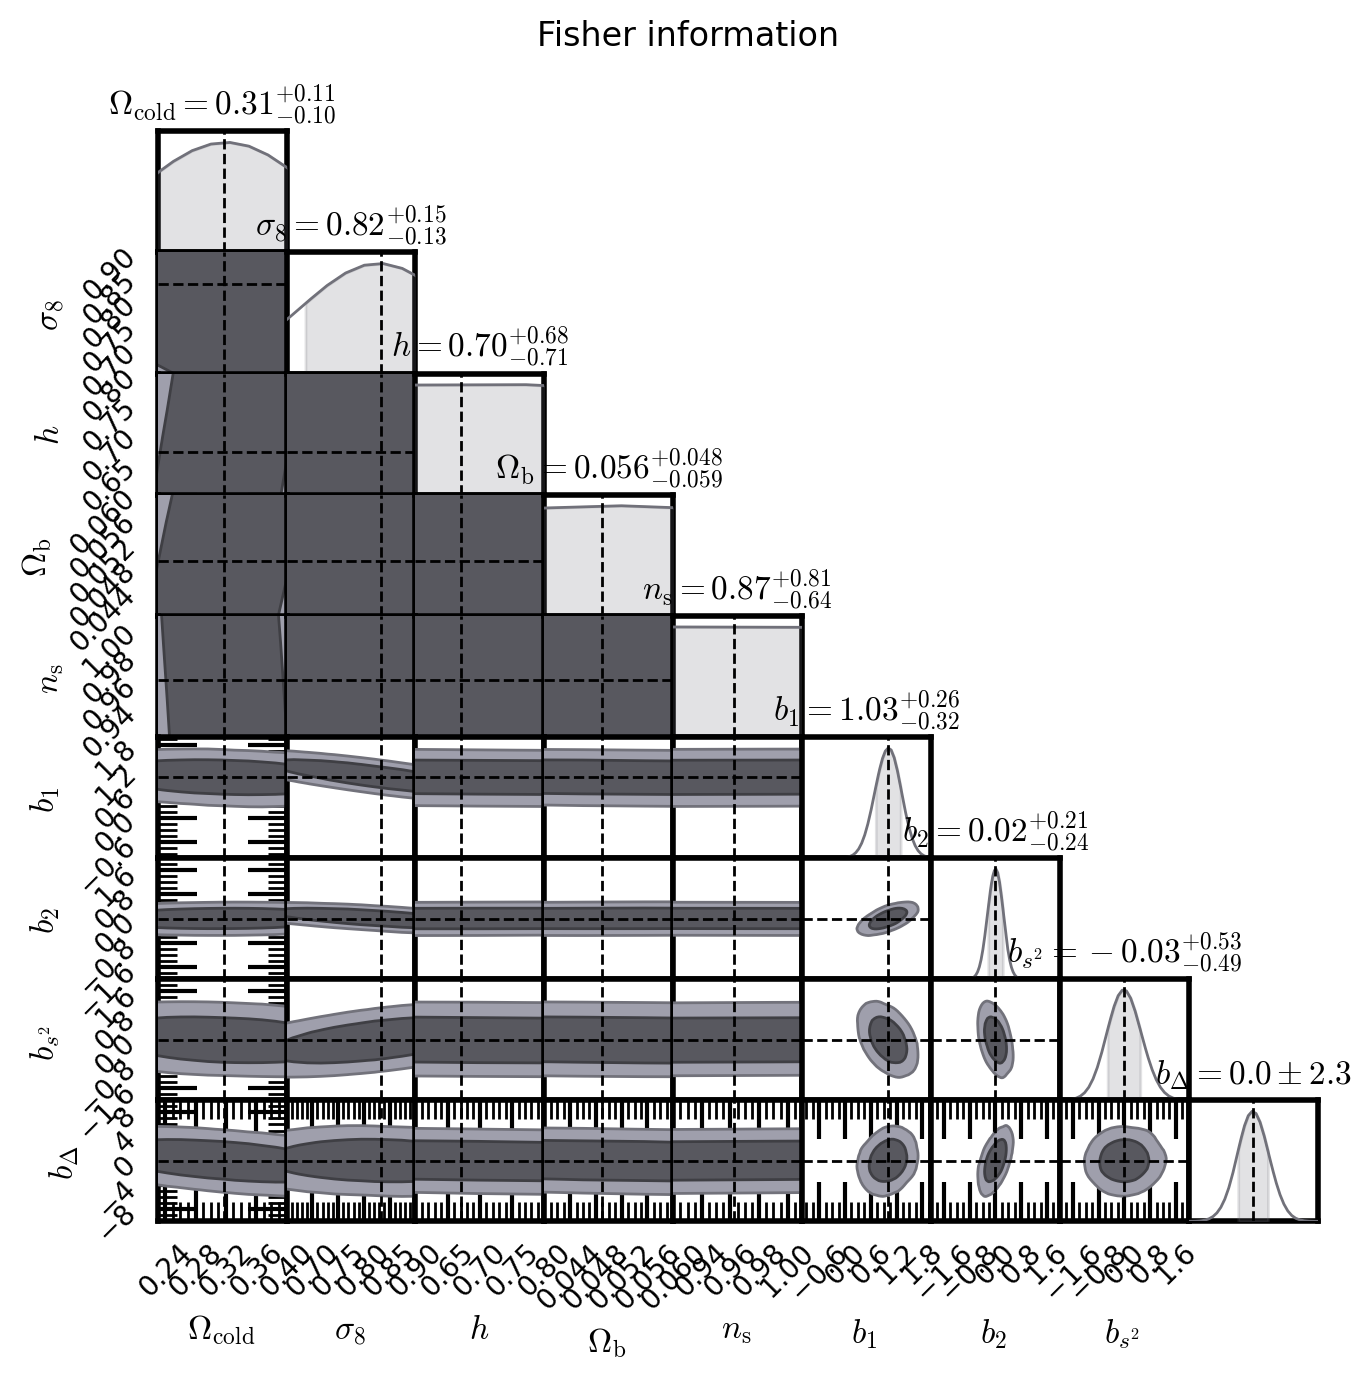

In [115]:

samples_arr = [samples_shift_biaszen_nd1]
labels = ['Fisher, muchisimocks, direct (n_delta=1)', '(n_delta=2)']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title='Fisher information', extents=extents, 
                  figsize=(7,7), fn_save=None)

['_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain10000_best-sbi-rand10']
fn_samples = ../results/results_sbi/sbi_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain10000_best-sbi-rand10/samples_test_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
(10000, 1, 9)


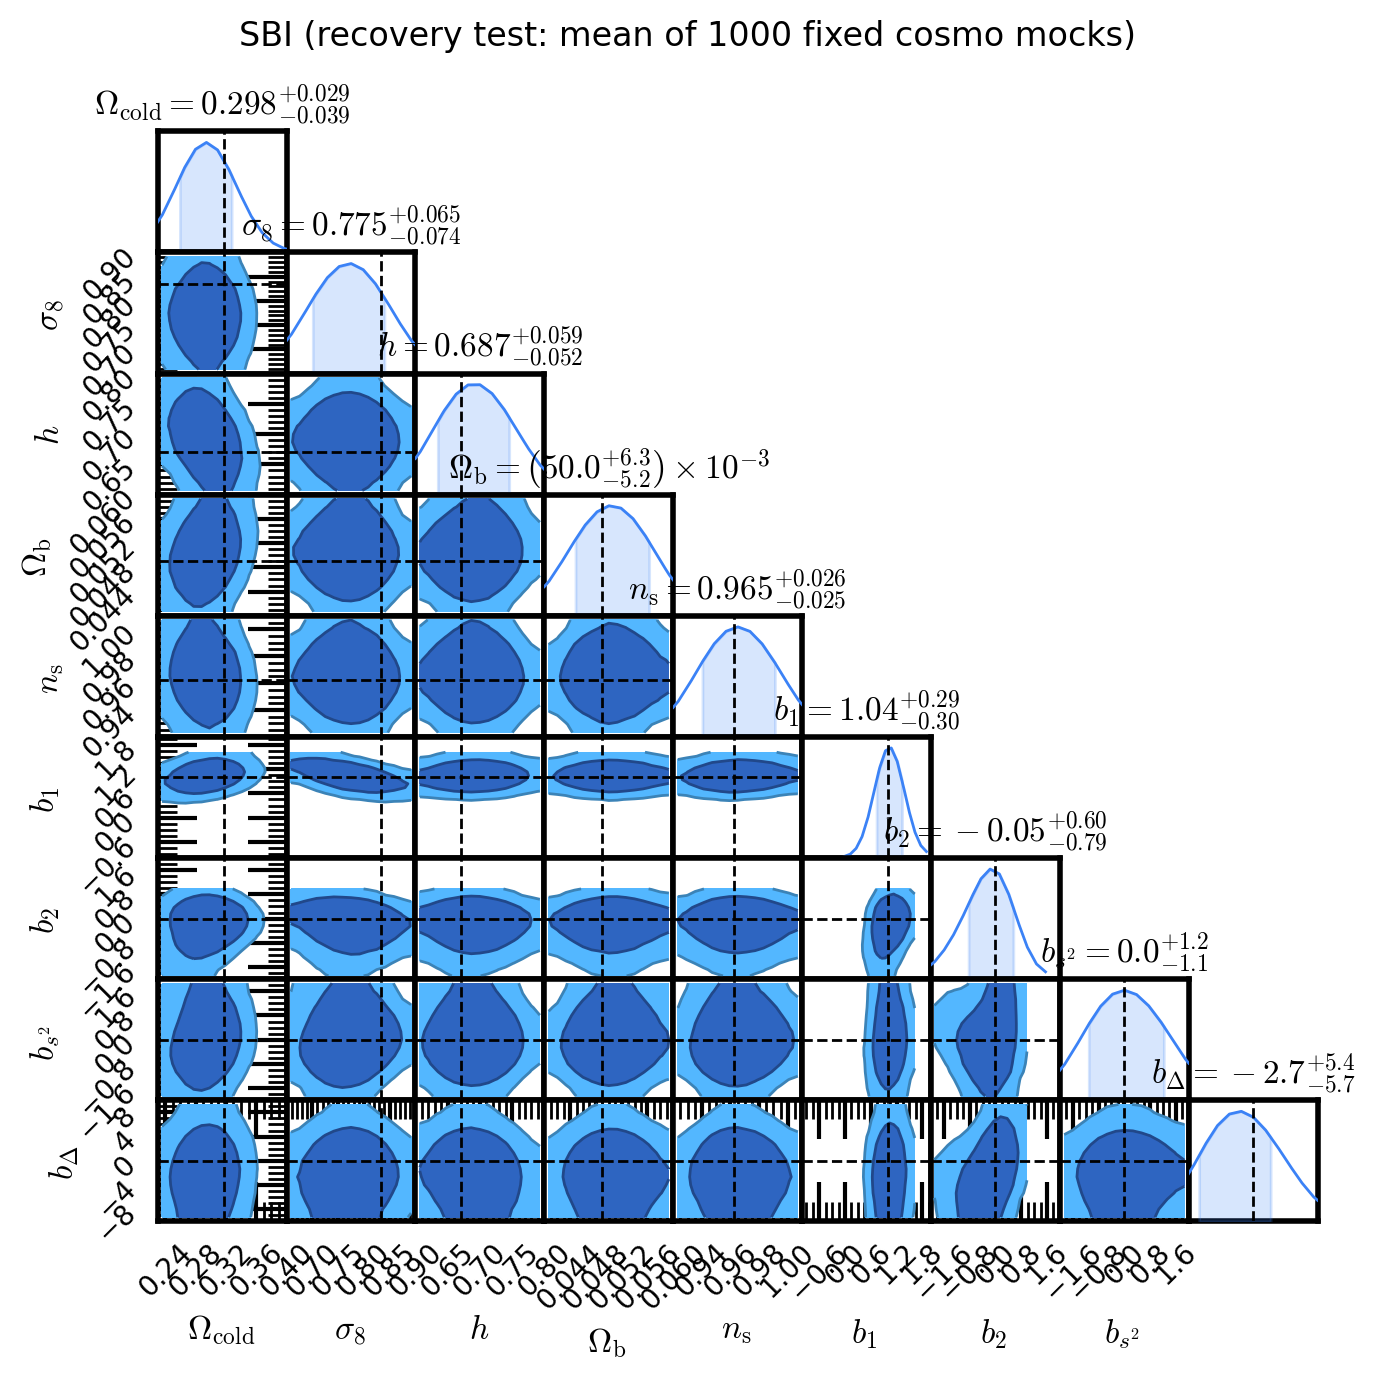

In [116]:
n_train = 10000
tag_params_train = '_p5_n10000'
tag_biasparams_train = '_biaszen_p4_n10000'
tag_biasparams_train_x10 = '_biaszen_p4_n100000'

inf_methods = [
               'sbi',
               #'fisher'
              ]
tags_inf = [
            f'_muchisimocksPk{tag_params_train}{tag_biasparams_train}_ntrain{n_train}_best-sbi-rand10',
            #'_muchisimocks_pk'
            ]
tags_test = [
             #f'{tag_data_test_fixed}_mean',
             '_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean',
             ''
            ]
labels_extra = [
                '',
                '',
                ]
title = 'SBI (recovery test: mean of 1000 fixed cosmo mocks)'
#title = 'SBI'
colors = ['blue', 'gray']

print(tags_inf)
param_names_vary = utils.param_names_all_ordered
idx_obs = 0
plotter.plot_contours_inf(param_names_vary, idx_obs, theta_fid, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels_extra=labels_extra,
                        title=title, extents=extents)